In [1]:
path_notebook = '/content/drive/MyDrive/Desafio_Kaggle/'

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
#drive.flush_and_unmount()

Mounted at /content/drive


In [3]:
import os
import sys
sys.path.insert(0, os.path.dirname(path_notebook))

In [4]:
import AleTransforms as trf
import AleDatasetAnalysis as dat
import AleMLAnalysis as aml
import AleExplainers as exp
import AleLearners as lrn

In [5]:
import importlib
importlib.reload(trf)
importlib.reload(dat)
importlib.reload(aml)
importlib.reload(exp)
importlib.reload(lrn)

<module 'AleLearners' from '/content/drive/MyDrive/Desafio_Kaggle/AleLearners.py'>

In [6]:
import tensorflow as tf
from IPython.display import Image

import pandas as pd
import numpy as np
import random
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

import itertools

# Dataset

In [7]:
#df = pd.read_csv('sample_data/california_housing_train.csv')
#df = pd.read_csv('https://gist.github.com/netj/8836201/raw/6f9306ad21398ea43cba4f7d537619d0e07d5ae3/iris.csv')
df = pd.read_csv('https://datahub.io/machine-learning/creditcard/r/creditcard.csv')

df

Time         V1         V2  ...       V28  Amount  Class
0            0.0  -1.359807  -0.072781  ... -0.021053  149.62    '0'
1            0.0   1.191857   0.266151  ...  0.014724    2.69    '0'
2            1.0  -1.358354  -1.340163  ... -0.059752  378.66    '0'
3            1.0  -0.966272  -0.185226  ...  0.061458  123.50    '0'
4            2.0  -1.158233   0.877737  ...  0.215153   69.99    '0'
...          ...        ...        ...  ...       ...     ...    ...
284802  172786.0 -11.881118  10.071785  ...  0.823731    0.77    '0'
284803  172787.0  -0.732789  -0.055080  ... -0.053527   24.79    '0'
284804  172788.0   1.919565  -0.301254  ... -0.026561   67.88    '0'
284805  172788.0  -0.240440   0.530483  ...  0.104533   10.00    '0'
284806  172792.0  -0.533413  -0.189733  ...  0.013649  217.00    '0'

[284807 rows x 31 columns]

In [8]:
df['Setosa'] = np.where(df['variety'] == 'Setosa', 1 , 0)
df['Virginica'] = np.where(df['variety'] == 'Virginica', 1 , 0)
df['Versicolor'] = np.where(df['variety'] == 'Versicolor', 1 , 0)

KeyError: ignored

In [9]:
frac_teste = 0.1

lista_teste = df.index[int((1-frac_teste)*len(df)):]
mask_teste = df.index.isin(lista_teste)
mask_treino = ~mask_teste

In [ ]:
frac_teste = 0.1

random.seed(42)
lista_teste = random.sample(list(df.index), int(frac_teste*len(df)))
mask_teste = df.index.isin(lista_teste)
mask_treino = ~mask_teste

In [ ]:
lista_seed = [42, 12, 7, 4, 1]
frac_val = 0.2 #1/len(lista_seed)

masks_trainval = []
for s in lista_seed:
  random.seed(s)
  lista_val = random.sample(list(df.loc[mask_treino, :].index), int(frac_val*np.sum(mask_treino)))
  mask_val = df.index.isin(lista_val)
  masks_trainval.append((~mask_val, mask_val))

In [ ]:
n_val = 4

corta_valores = trf.CortaIntervalosQuasiUniforme(df.loc[mask_treino, 'median_house_value'].values, num_div = 4)
valores_disc = corta_valores.aplica_discretizacao(df.loc[mask_treino, 'median_house_value'].values)

masks_trainval = []
for i in range(0, n_val):
  mask_val = mask_treino.copy()
  mask_val[mask_treino] = valores_disc == i
  mask_train = mask_treino.copy()
  mask_train[mask_treino] = valores_disc != i
  masks_trainval.append((mask_train, mask_val))

In [10]:
n_val = 4

corta_valores = trf.CortaIntervalosQuasiUniforme(df.loc[mask_treino, 'Time'].values, num_div = 4)
valores_disc = corta_valores.aplica_discretizacao(df.loc[mask_treino, 'Time'].values)

masks_trainval = []
for i in range(0, n_val):
  mask_val = mask_treino.copy()
  mask_val[mask_treino] = valores_disc == i
  mask_train = mask_treino.copy()
  mask_train[mask_treino] = valores_disc != i
  masks_trainval.append((mask_train, mask_val))

In [11]:
df = df.drop('Time', axis = 1)

# Construção da Rede

In [12]:
def cria_rede_encoder(camada_entrada, latent_dim, k):
  lista_neuronios = [32, 16]
  lista_camadas = [camada_entrada]
  for i in range(0, len(lista_neuronios)):
    n = lista_neuronios[i]
    lista_camadas.append(tf.keras.layers.Dense(n, activation = 'relu', name = f'e_c{str(i)}_{str(k)}')(lista_camadas[-1]))
  camada_saida = tf.keras.layers.Dense(latent_dim, activation = 'sigmoid', name = f'el_{str(k)}')(lista_camadas[-1])
  return camada_saida

def cria_rede_clusterizador(encoder, n_clusters, k):
  lista_neuronios = [] #[8, 8]
  lista_camadas = [encoder]
  for i in range(0, len(lista_neuronios)):
    n = lista_neuronios[i]
    lista_camadas.append(tf.keras.layers.Dense(n, activation = 'relu', name = f'cl_c{str(i)}_{str(k)}')(lista_camadas[-1]))
  camada_saida = tf.keras.layers.Dense(n_clusters, activation = 'softmax', name = f'cl_{str(k)}')(lista_camadas[-1])
  return camada_saida

#Pode receber como entrada o encoder ou o clusterizador
def cria_rede_decoder(encoder, dim_saida, k):
  lista_neuronios = [16, 32]
  lista_camadas = [encoder]
  for i in range(0, len(lista_neuronios)):
    n = lista_neuronios[i]
    lista_camadas.append(tf.keras.layers.Dense(n, activation = 'relu', name = f'd_c{str(i)}_{str(k)}')(lista_camadas[-1]))
  camada_saida = tf.keras.layers.Dense(dim_saida, activation = 'linear', name = f'saida_{str(k)}')(lista_camadas[-1])
  return camada_saida

In [13]:
class ThresholdLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim = 2, **kwargs):
        super(ThresholdLayer, self).__init__(**kwargs)

        initializer = tf.keras.initializers.Constant(1/input_dim)
        self.thrs = tf.Variable(initial_value = initializer(shape = (input_dim,), dtype = "float32"), 
                                trainable = True)

    def call(self, x):
        #flag = tf.greater_equal(x, self.thrs)
        #return tf.where(flag, x = tf.ones_like(x), y = tf.zeros_like(x))
        return tf.keras.backend.sigmoid(100*(x - self.thrs))

In [14]:
#features = list(df.columns)

#alvo = 'variety'
alvo = 'Class'
features = [f for f in df.columns if f != alvo]

In [15]:
N = len(masks_trainval)
n_features = len(features)
latent_dim = 2
n_clusters = 4

In [16]:
####################################

camada_entrada_encoder = tf.keras.layers.Input(n_features, name = 'entrada_e')
lista_encoders = []
for i in range(N):
  lista_encoders.append(cria_rede_encoder(camada_entrada_encoder, latent_dim, i))

#Representação Latente
encoded = tf.keras.layers.Average(name = 'espaco_latente')(lista_encoders)

encoder = tf.keras.models.Model(inputs = camada_entrada_encoder, outputs = encoded, name = 'encoder')

####################################

camada_entrada_cluterizador = tf.keras.layers.Input(shape = latent_dim, name = 'entrada_cl')
lista_clusterizadores = []
for i in range(N):
  lista_clusterizadores.append(cria_rede_clusterizador(camada_entrada_cluterizador, n_clusters, i))

clusterized = tf.keras.layers.Average(name = 'clusterizador')(lista_clusterizadores)

clusterizador = tf.keras.models.Model(inputs = camada_entrada_cluterizador, outputs = clusterized, name = 'clusterizador')

####################################

camada_entrada_decoder = tf.keras.layers.Input(shape = n_clusters, name = 'entrada_d')
lista_decoders = []
for i in range(N):
  lista_decoders.append(cria_rede_decoder(camada_entrada_decoder, n_features, i))

decoded = tf.keras.layers.Average(name = 'saida')(lista_decoders)

decoder = tf.keras.models.Model(inputs = camada_entrada_decoder, outputs = decoded, name = 'decoder')

####################################

camada_entrada = tf.keras.layers.Input(n_features, name = 'entrada')
encoded = encoder(camada_entrada)
clusterized = clusterizador(encoded)
decoded = decoder(clusterized)
autoencoder = tf.keras.models.Model(inputs = camada_entrada, outputs = decoded, name = 'autoencoder')

pesos_iniciais = autoencoder.get_weights()

In [17]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
entrada (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
encoder (Functional)         (None, 2)                 6088      
_________________________________________________________________
clusterizador (Functional)   (None, 4)                 48        
_________________________________________________________________
decoder (Functional)         (None, 29)                6324      
Total params: 12,460
Trainable params: 12,460
Non-trainable params: 0
_________________________________________________________________


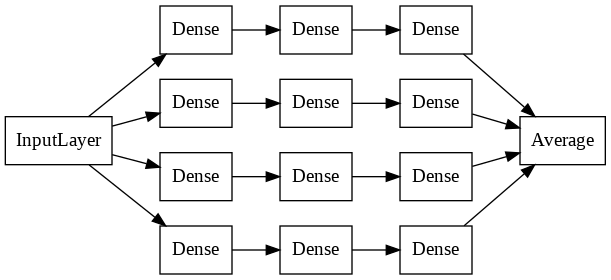

In [18]:
encoder_dot = tf.keras.utils.model_to_dot(
    encoder,
    show_shapes = False,
    show_dtype = False,
    show_layer_names = False,
    rankdir = 'LR', #'TB', 'LR'
    expand_nested = False,
    dpi = 96,
    subgraph = False,
    layer_range = None,
)
display(Image(encoder_dot.create_png()))

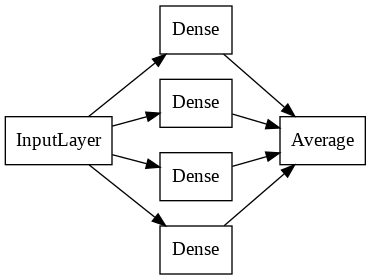

In [19]:
clusterizador_dot = tf.keras.utils.model_to_dot(
    clusterizador,
    show_shapes = False,
    show_dtype = False,
    show_layer_names = False,
    rankdir = 'LR', #'TB', 'LR'
    expand_nested = False,
    dpi = 96,
    subgraph = False,
    layer_range = None,
)
display(Image(clusterizador_dot.create_png()))

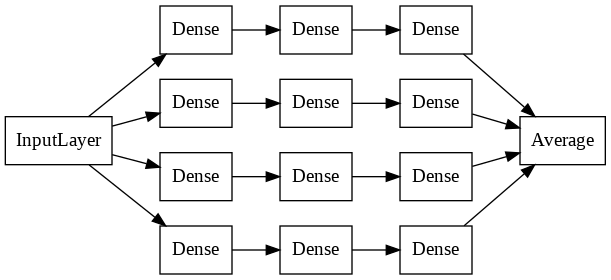

In [20]:
decoder_dot = tf.keras.utils.model_to_dot(
    decoder,
    show_shapes = False,
    show_dtype = False,
    show_layer_names = False,
    rankdir = 'LR', #'TB', 'LR'
    expand_nested = False,
    dpi = 96,
    subgraph = False,
    layer_range = None,
)
display(Image(decoder_dot.create_png()))

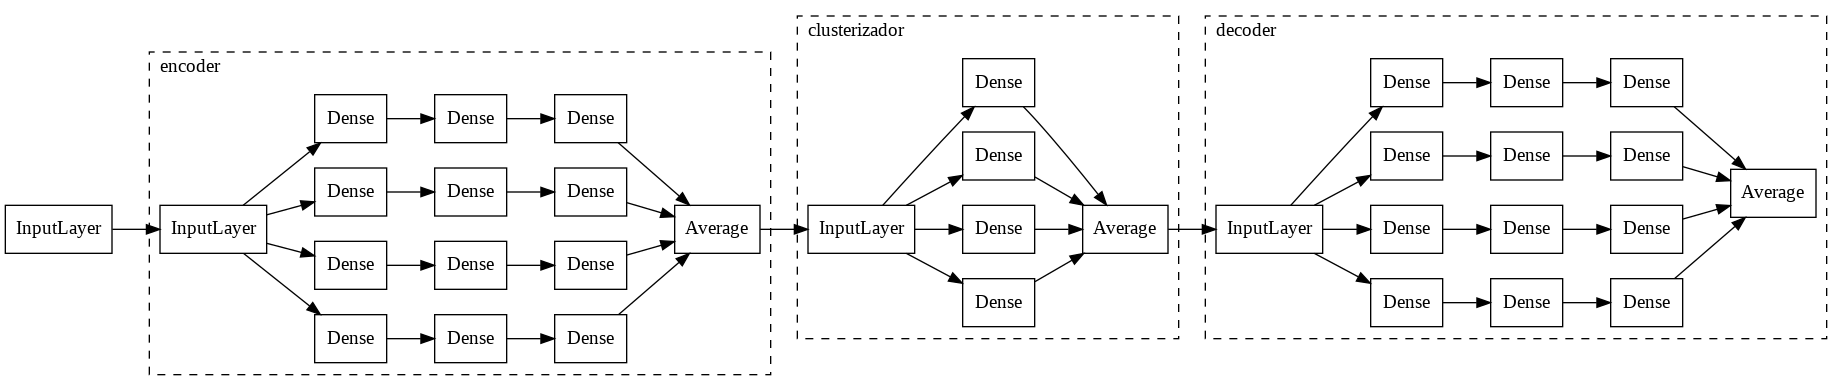

In [21]:
autoencoder_dot = tf.keras.utils.model_to_dot(
    autoencoder,
    show_shapes = False,
    show_dtype = False,
    show_layer_names = False,
    rankdir = 'LR', #'TB', 'LR'
    expand_nested = True,
    dpi = 96,
    subgraph = False,
    layer_range = None,
)
display(Image(autoencoder_dot.create_png()))

# Treinamento da Rede

In [22]:
def reseta_todas_camadas_treinaveis(encoder, clusterizador, decoder):
  for camada in encoder.layers:
    camada.trainable = True
  for camada in clusterizador.layers:
    camada.trainable = True
  for camada in decoder.layers:
    camada.trainable = True

def altera_camadas_treinaveis(encoder, clusterizador, decoder, k):
  for camada in encoder.layers:
    if camada.name[-len(f'_{str(k)}'):] == f'_{str(k)}':
      camada.trainable = True
    else:
      camada.trainable = False
  for camada in clusterizador.layers:
    if camada.name[-len(f'_{str(k)}'):] == f'_{str(k)}':
      camada.trainable = True
    else:
      camada.trainable = False
  for camada in decoder.layers:
    if camada.name[-len(f'_{str(k)}'):] == f'_{str(k)}':
      camada.trainable = True
    else:
      camada.trainable = False

In [23]:
def plot_curva_vies_variancia(curvas_vies_variancia, lista_mses_ref, figsize = [6, 4]):
  paleta_cores = sns.color_palette("colorblind")
  with sns.axes_style("whitegrid"):
    for j in range(0, len(curvas_vies_variancia)):
      fig, ax = plt.subplots(1, 1, figsize = figsize)
      epocas = np.arange(1, len(curvas_vies_variancia[j][0]) + 1)
      r2_train = 1 - curvas_vies_variancia[j][0]/lista_mses_ref[j][0]
      r2_val = 1 - curvas_vies_variancia[j][1]/lista_mses_ref[j][1]
      ax.plot(epocas, r2_train, color = paleta_cores[0], label = 'Treino')
      ax.plot(epocas, r2_val, color = paleta_cores[1], label = 'Validacao')
      ax.set_xlabel('Época')
      ax.set_ylabel('R2')
      ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
      plt.show()

In [24]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.01)
mse = tf.keras.losses.MeanSquaredError()
autoencoder.compile(loss = mse, optimizer = opt)

In [25]:
medias = np.mean(df.loc[mask_treino, features].values, axis = 0)
desvios = np.std(df.loc[mask_treino, features].values, axis = 0)

def norm(X, medias, desvios):
  return (X - medias)/desvios

In [32]:
n_loops = 200
epocas_por_loop = 2
n_batchs = 32

reseta_todas_camadas_treinaveis(encoder, clusterizador, decoder)
autoencoder.set_weights(pesos_iniciais)

callback = tf.keras.callbacks.ModelCheckpoint(
                                              'pesos_callback.h5', #hdf5
                                              monitor = 'val_loss',
                                              verbose = False,
                                              save_best_only = True,
                                              save_weights_only = True,
                                              mode = 'min',
                                              save_freq = 'epoch',
                                              )

curvas_vies_variancia = [[[], []] for v in masks_trainval]
lista_mses_ref = []

for i in range(0, n_loops):
  for j in range(0, len(masks_trainval)):
    tupla = masks_trainval[j]
    x_train = norm(df.loc[tupla[0], features].values, medias, desvios)
    x_val = norm(df.loc[tupla[1], features].values, medias, desvios)

    if(i == 0):
      lista_mses_ref.append((mse(x_train, np.zeros(shape = x_train.shape)).numpy(), 
                             mse(x_val, np.zeros(shape = x_val.shape)).numpy()))

    altera_camadas_treinaveis(encoder, clusterizador, decoder, j)

    H = autoencoder.fit(x_train, x_train,
                        validation_data = (x_val, x_val),
                        epochs = epocas_por_loop,
                        batch_size = math.ceil(np.sum(tupla[0])/n_batchs), 
                        callbacks = callback,
                        verbose = True)
    
    reseta_todas_camadas_treinaveis(encoder, clusterizador, decoder)

    argmin = np.argmin(H.history['val_loss'])
    curvas_vies_variancia[j][0].extend(H.history['loss'][:argmin+1])
    curvas_vies_variancia[j][1].extend(H.history['val_loss'][:argmin+1])
    autoencoder.load_weights('pesos_callback.h5')

Epoch 1/2
32/32 [==============================] - 0s 11ms/step - loss: 0.9824 - val_loss: 1.0602
Epoch 2/2
32/32 [==============================] - 0s 9ms/step - loss: 0.9818 - val_loss: 1.0594
Epoch 1/2
32/32 [==============================] - 0s 9ms/step - loss: 1.0410 - val_loss: 0.8767
Epoch 2/2
32/32 [==============================] - 0s 8ms/step - loss: 1.0311 - val_loss: 0.8593
Epoch 1/2
32/32 [==============================] - 0s 9ms/step - loss: 0.9528 - val_loss: 1.0299
Epoch 2/2
32/32 [==============================] - 0s 8ms/step - loss: 0.9447 - val_loss: 1.0296
Epoch 1/2
32/32 [==============================] - 0s 9ms/step - loss: 0.9620 - val_loss: 1.0159
Epoch 2/2
32/32 [==============================] - 0s 8ms/step - loss: 0.9489 - val_loss: 1.0294
Epoch 1/2
32/32 [==============================] - 0s 9ms/step - loss: 0.9542 - val_loss: 1.0314
Epoch 2/2
32/32 [==============================] - 0s 9ms/step - loss: 0.9477 - val_loss: 1.0300
Epoch 1/2
32/32 [============

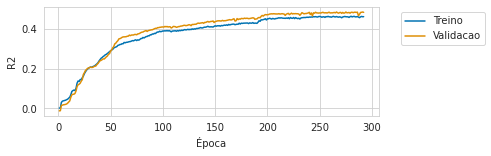

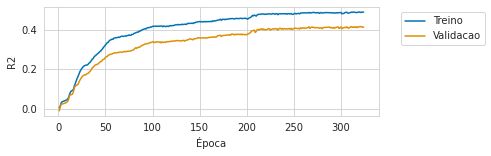

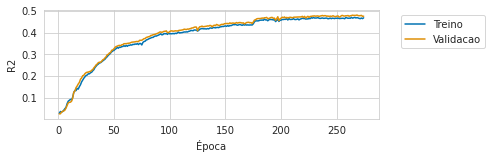

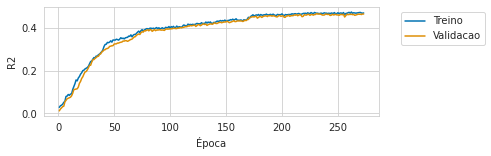

In [33]:
plot_curva_vies_variancia(curvas_vies_variancia, lista_mses_ref, figsize = [6, 2])

# Avaliação

In [34]:
def calcula_r2(mse, autoencoder, X, medias, desvios):
  X_norm = norm(X, medias, desvios)
  mse_ref = mse(X_norm, np.zeros(shape = X.shape)).numpy()
  pred = autoencoder.predict(X_norm)
  mse_x = mse(X_norm, pred).numpy()
  return 1 - mse_x/mse_ref

In [35]:
dict_r2 = {
          'Treino': calcula_r2(mse, autoencoder, df.loc[mask_treino, features].values, medias, desvios),
          'Teste': calcula_r2(mse, autoencoder, df.loc[mask_teste, features].values, medias, desvios)
          }

In [36]:
display(pd.DataFrame(pd.Series(dict_r2)))

0
Treino  0.474126
Teste   0.456532

# Espaço Latente

In [94]:
def plot_espaco_latente(dict_encoded, frac = 1.0, alpha = 1.0, size = 1.0, seed = 42, figsize = [6, 6]):
  paleta_cores = sns.color_palette("colorblind")
  A = mpl.rcParams['lines.markersize'] ** 2
  with sns.axes_style("whitegrid"):
      fig, ax = plt.subplots(1, 1, figsize = figsize)
      ax.set_xlabel('Feature 0')
      ax.set_ylabel('Feature 1')
      ax.set_xlim(-0.05, 1.05)
      ax.set_ylim(-0.05, 1.05)
      ax.grid(False)
      ax.set_aspect('equal', adjustable = 'box')
      i = 0
      hlds = []
      for chave in dict_encoded.keys():
        x = dict_encoded[chave][:, 0]
        y = dict_encoded[chave][:, 1]
        random.seed(seed)
        indices = random.sample(list(range(0, x.size)), int(frac*x.size))
        ax.scatter(x[indices], y[indices], alpha = alpha, s = size*A, color = paleta_cores[i])
        hlds.append(mpl.patches.Patch(color = paleta_cores[i], label = chave))
        i = i + 1
      ax.legend(handles = hlds, bbox_to_anchor = (1.05, 1), loc = 'upper left')
      plt.show()

In [38]:
encoded_treino = encoder.predict(norm(df.loc[mask_treino, features].values, medias, desvios))
encoded_teste = encoder.predict(norm(df.loc[mask_teste, features].values, medias, desvios))

In [39]:
dict_encoded = {
                'Treino': encoded_treino,
                'Teste': encoded_teste
                }

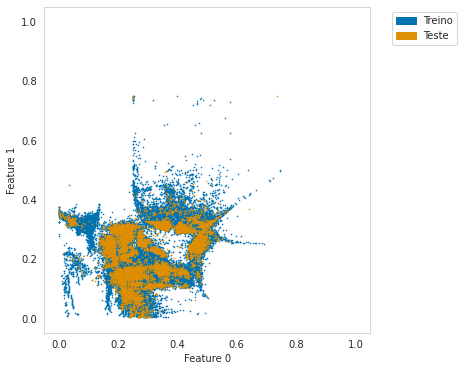

In [95]:
plot_espaco_latente(dict_encoded, frac = 1.0, alpha = 1.0, size = 0.01, seed = 42, figsize = [6, 6])

# Clusterização

In [41]:
def predict_cluster(clusters_prob, probs_corte, probs_max, grau_confianca = 0):
  if(grau_confianca == 0):
    clusters = np.argmax((clusters_prob - probs_corte)/(probs_max - probs_corte), axis = 1)
  else:
    clusters = -1*np.ones(clusters_prob.shape[0])
    prob_norm = np.max((clusters_prob - probs_corte)/(probs_max - probs_corte), axis = 1)
    flag_confianca = prob_norm >= grau_confianca
    clusters[flag_confianca] = np.argmax((clusters_prob[flag_confianca] - probs_corte)/(probs_max - probs_corte), axis = 1)
  return clusters.astype(int)

def predict_confianca_cluster(clusters_prob, probs_corte, probs_max):
  prob_norm = np.max((clusters_prob - probs_corte)/(probs_max - probs_corte), axis = 1)
  return np.array([min(1, p) for p in prob_norm])

In [88]:
def plot_clusters(encoded, clusters, frac = 1, alpha = 1.0, size = 1.0, seed = 42, figsize = [6, 6]):
  paleta_cores = sns.color_palette("colorblind")
  A = mpl.rcParams['lines.markersize'] ** 2
  with sns.axes_style("whitegrid"):
      fig, ax = plt.subplots(1, 1, figsize = figsize)
      ax.set_xlabel('Feature 0')
      ax.set_ylabel('Feature 1')
      ax.set_xlim(-0.05, 1.05)
      ax.set_ylim(-0.05, 1.05)
      ax.grid(False)
      ax.set_aspect('equal', adjustable = 'box')
      hlds = []
      for cluster in np.unique(clusters):
        if(cluster == -1):
          x = encoded[clusters == cluster, 0]
          y = encoded[clusters == cluster, 1]
          random.seed(seed)
          indices = random.sample(list(range(0, x.size)), int(frac*x.size))
          ax.scatter(x[indices], y[indices], alpha = alpha, s = size*A, color = 'black')
          hlds.append(mpl.patches.Patch(color = 'black', label = f'Cluster {str(cluster)}'))
        else:
          x = encoded[clusters == cluster, 0]
          y = encoded[clusters == cluster, 1]
          random.seed(seed)
          indices = random.sample(list(range(0, x.size)), int(frac*x.size))
          ax.scatter(x[indices], y[indices], alpha = alpha, s = size*A, color = paleta_cores[cluster])
          hlds.append(mpl.patches.Patch(color = paleta_cores[cluster], label = f'Cluster {str(cluster)}'))
      ax.legend(handles = hlds, bbox_to_anchor = (1.05, 1), loc = 'upper left')
      plt.show()

def plot_contorno_clusters(clusterizador, probs_corte, probs_max, plot_confianca = True, N = 100, figsize = [6, 6]):
  pontos = (np.arange(0, N) + 0.5)/N
  encoded_grid = np.array(list(itertools.product(pontos, pontos)))
  clusters_prob = clusterizador.predict(encoded_grid)
  clusters = predict_cluster(clusters_prob, probs_corte, probs_max)
  confianca = predict_confianca_cluster(clusters_prob, probs_corte, probs_max)

  paleta_cores = sns.color_palette("colorblind")
  with sns.axes_style("whitegrid"):
      fig, ax = plt.subplots(1, 1, figsize = figsize)
      ax.set_xlabel('Feature 0')
      ax.set_ylabel('Feature 1')
      ax.set_xlim(-0.05, 1.05)
      ax.set_ylim(-0.05, 1.05)
      ax.grid(False)
      ax.set_aspect('equal', adjustable = 'box')
      L = 1/N
      hlds = []
      for cluster in np.unique(clusters):
        if(cluster == -1):
          x = encoded_grid[clusters == cluster, 0]
          y = encoded_grid[clusters == cluster, 1]
          for x, y in zip(x, y):
            ax.add_artist(Rectangle(xy = (x, y), color = 'white', width = L, height = L, zorder = 0))
          hlds.append(mpl.patches.Patch(color = 'white', label = f'Cluster {str(cluster)}'))
        else:
          x = encoded_grid[clusters == cluster, 0]
          y = encoded_grid[clusters == cluster, 1]
          if(plot_confianca):
            confianca = 0.9*confianca + 0.1
            cores = [paleta_cores[cluster] + (a,) for a in confianca[clusters == cluster]]
          else:
            cores = [paleta_cores[cluster] for a in confianca[clusters == cluster]]
          for x, y, c in zip(x, y, cores):
            ax.add_artist(Rectangle(xy = (x, y), color = c, linewidth = 0, width = L, height = L, zorder = 0))
          hlds.append(mpl.patches.Patch(color = paleta_cores[cluster], label = f'Cluster {str(cluster)}'))
      ax.legend(handles = hlds, bbox_to_anchor = (1.05, 1), loc = 'upper left')
      plt.show()

def plot_contorno_clusters_e_pontos(encoded, clusterizador, probs_corte, probs_max, plot_confianca = True, N = 100, 
                                    alpha = 1.0, size = 1.0, figsize = [6, 6]):
  pontos = (np.arange(0, N) + 0.5)/N
  encoded_grid = np.array(list(itertools.product(pontos, pontos)))
  clusters_prob = clusterizador.predict(encoded_grid)
  clusters = predict_cluster(clusters_prob, probs_corte, probs_max)
  confianca = predict_confianca_cluster(clusters_prob, probs_corte, probs_max)

  paleta_cores = sns.color_palette("colorblind")
  A = mpl.rcParams['lines.markersize'] ** 2
  with sns.axes_style("whitegrid"):
      fig, ax = plt.subplots(1, 1, figsize = figsize)
      ax.set_xlabel('Feature 0')
      ax.set_ylabel('Feature 1')
      ax.set_xlim(-0.05, 1.05)
      ax.set_ylim(-0.05, 1.05)
      ax.grid(False)
      ax.set_aspect('equal', adjustable = 'box')
      L = 1/N
      hlds = []      
      for cluster in np.unique(clusters):
        if(cluster == -1):
          x = encoded_grid[clusters == cluster, 0]
          y = encoded_grid[clusters == cluster, 1]
          for x, y in zip(x, y):
            ax.add_artist(Rectangle(xy = (x, y), color = 'white', width = L, height = L, zorder = 0))
          hlds.append(mpl.patches.Patch(color = 'white', label = f'Cluster {str(cluster)}'))
        else:
          x = encoded_grid[clusters == cluster, 0]
          y = encoded_grid[clusters == cluster, 1]
          if(plot_confianca):
            confianca = 0.9*confianca + 0.1
            cores = [paleta_cores[cluster] + (a,) for a in confianca[clusters == cluster]]
          else:
            cores = [paleta_cores[cluster] for a in confianca[clusters == cluster]]
          for x, y, c in zip(x, y, cores):
            ax.add_artist(Rectangle(xy = (x, y), color = c, linewidth = 0, width = L, height = L, zorder = 0))
          hlds.append(mpl.patches.Patch(color = paleta_cores[cluster], label = f'Cluster {str(cluster)}'))
      ax.scatter(encoded[:, 0], encoded[:, 1], color = 'black', alpha = alpha, s = size*A)
      ax.legend(handles = hlds, bbox_to_anchor = (1.05, 1), loc = 'upper left')
      plt.show()

In [48]:
clusters_prob_treino = clusterizador.predict(encoded_treino)
clusters_prob_teste = clusterizador.predict(encoded_teste)

In [49]:
probs_corte = np.mean(clusters_prob_treino, axis = 0)
probs_max = np.max(clusters_prob_treino, axis = 0)
print(probs_corte)
print(probs_max)

[0.08792692 0.2068603  0.30557752 0.39959618]
[0.20937924 0.5017719  0.5065358  0.82008797]


In [50]:
clusters_treino = predict_cluster(clusters_prob_treino, probs_corte, probs_max, grau_confianca = 0.0)
clusters_teste = predict_cluster(clusters_prob_teste, probs_corte, probs_max, grau_confianca = 0.0)

Treino


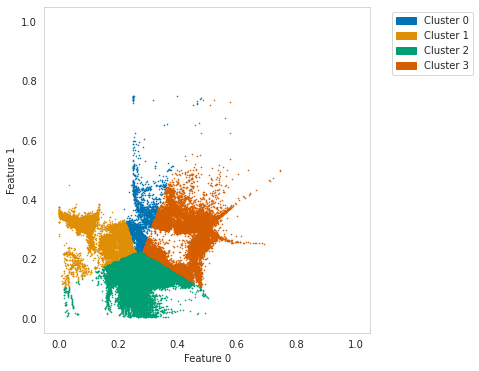

Teste


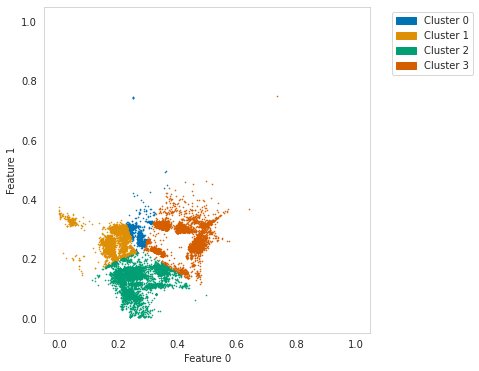

In [92]:
print('Treino')
plot_clusters(encoded_treino, clusters_treino, frac = 1.0, alpha = 1.0, size = 0.01, seed = 42, figsize = [6, 6])
print('Teste')
plot_clusters(encoded_teste, clusters_teste, frac = 1.0, alpha = 1.0, size = 0.01, seed = 42, figsize = [6, 6])

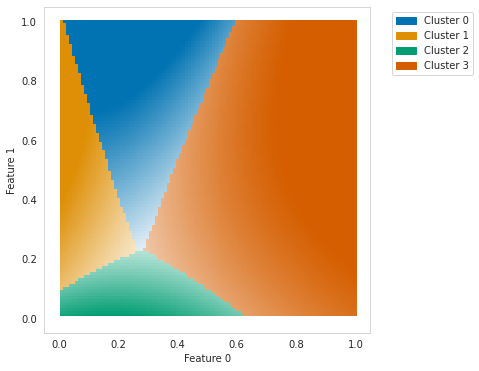

In [96]:
plot_contorno_clusters(clusterizador, probs_corte, probs_max, figsize = [6, 6])
#plot_contorno_clusters(clusterizador, probs_corte, probs_max, plot_confianca = False, figsize = [6, 6]) 

Treino


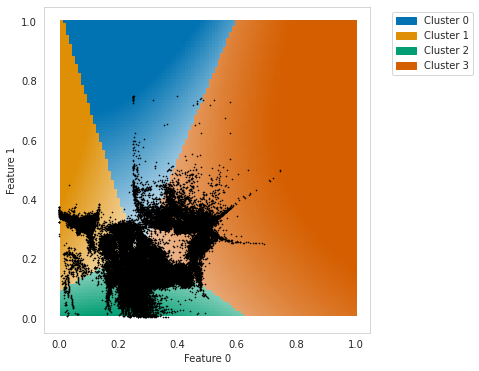

Teste


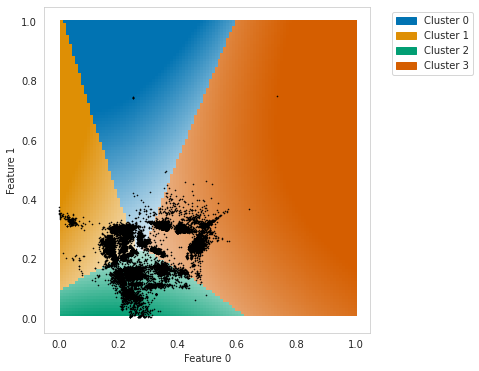

In [93]:
print('Treino')
plot_contorno_clusters_e_pontos(encoded_treino, clusterizador, probs_corte, probs_max, alpha = 1.0, size = 0.01, figsize = [6, 6])
print('Teste')
plot_contorno_clusters_e_pontos(encoded_teste, clusterizador, probs_corte, probs_max, alpha = 1.0, size = 0.01, figsize = [6, 6])

# Detecção de Anomalias

In [54]:
def predict_grau_anomalia(X, pred, mse, medias,desvios):
  X_norm = norm(X, medias, desvios)
  mse_x = np.mean(np.power(X_norm - pred, 2), axis = 1)
  return mse_x

In [86]:
def plot_anomalias(encoded, grau_anomalia, corte_anomalia = 0, alpha = 1.0, seed = 42, figsize = [6, 6]):
  paleta_cores = sns.color_palette("colorblind")
  A = mpl.rcParams['lines.markersize'] ** 2
  with sns.axes_style("whitegrid"):
      fig, ax = plt.subplots(1, 1, figsize = figsize)
      ax.set_xlabel('Feature 0')
      ax.set_ylabel('Feature 1')
      ax.set_xlim(-0.05, 1.05)
      ax.set_ylim(-0.05, 1.05)
      ax.grid(False)
      ax.set_aspect('equal', adjustable = 'box')

      sizes = np.array([int((1 + g)*A) for g in grau_anomalia])/np.max(grau_anomalia)
      anomalias = grau_anomalia > corte_anomalia

      ax.scatter(encoded[~anomalias, 0], encoded[~anomalias, 1], s = sizes[~anomalias], color = paleta_cores[0], alpha = alpha)
      #ax.scatter(encoded[~anomalias, 0], encoded[~anomalias, 1], color = paleta_cores[0], alpha = alpha)

      ax.scatter(encoded[anomalias, 0], encoded[anomalias, 1], s = sizes[anomalias], color = paleta_cores[1], alpha = alpha)
      #ax.scatter(encoded[anomalias, 0], encoded[anomalias, 1], color = paleta_cores[1], alpha = alpha)

      hlds = []
      hlds.append(mpl.patches.Patch(color = paleta_cores[0], label = 'Normais'))
      hlds.append(mpl.patches.Patch(color = paleta_cores[1], label = 'Anomalias'))
      ax.legend(handles = hlds, bbox_to_anchor = (1.05, 1), loc = 'upper left')
      plt.show()

In [56]:
predict_treino = autoencoder.predict(norm(df.loc[mask_treino, features].values, medias, desvios))
predict_teste = autoencoder.predict(norm(df.loc[mask_teste, features].values, medias, desvios))

In [57]:
grau_an_treino = predict_grau_anomalia(df.loc[mask_treino, features].values, predict_treino, mse, medias, desvios)
grau_an_teste = predict_grau_anomalia(df.loc[mask_teste, features].values, predict_teste, mse, medias, desvios)

In [60]:
#'0'    0.998166
#'1'    0.001834

frac_an = 0.01
corte_anomalia = np.sort(grau_an_treino)[-int(frac_an*grau_an_treino.size)]
print(corte_anomalia)

3.409252741853412


Treino


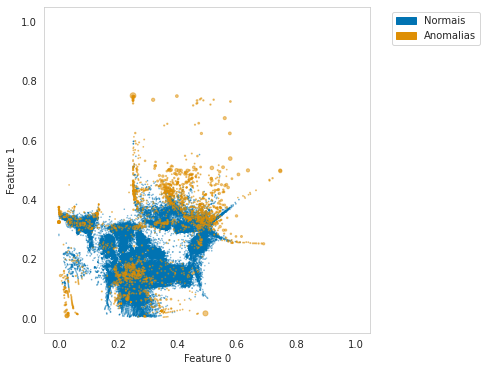

Teste


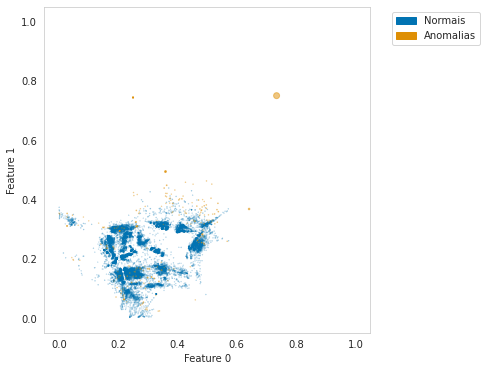

In [87]:
print('Treino')
plot_anomalias(encoded_treino, grau_an_treino, corte_anomalia = corte_anomalia, alpha = 0.5, seed = 42, figsize = [6, 6])
print('Teste')
plot_anomalias(encoded_teste, grau_an_teste, corte_anomalia = corte_anomalia, alpha = 0.5, seed = 42, figsize = [6, 6])

# Análises Clusters

In [63]:
def plot_bivariadas_clusters(df, frac = 1, alpha = 0.1, seed = 42, figsize = [6, 4]):
  paleta_cores = sns.color_palette("colorblind")
  with sns.axes_style("whitegrid"):
      fig, ax = plt.subplots(1, 1, figsize = figsize)
      hlds = []
      for cluster in df.index:
        if(cluster == -1):
          x = df.loc[cluster, df.columns[0]]
          y = df.loc[cluster, df.columns[1]]
          random.seed(seed)
          indices = random.sample(list(range(0, x.size)), int(frac*x.size))
          ax.scatter(x[indices], y[indices], alpha = alpha, color = 'black')
          hlds.append(mpl.patches.Patch(color = 'black', label = f'Cluster {str(cluster)}'))
        else:
          x = df.loc[cluster, df.columns[0]]
          y = df.loc[cluster, df.columns[1]]
          random.seed(seed)
          indices = random.sample(list(range(0, x.size)), int(frac*x.size))
          ax.scatter(x[indices], y[indices], alpha = alpha, color = paleta_cores[cluster])
          hlds.append(mpl.patches.Patch(color = paleta_cores[cluster], label = f'Cluster {str(cluster)}'))
      ax.set_xlabel(df.columns[0])
      ax.set_ylabel(df.columns[1])
      ax.legend(handles = hlds, bbox_to_anchor = (1.05, 1), loc = 'upper left')
      plt.show()

In [64]:
print('Treino')
df_aux = df.loc[mask_treino, features].copy()
df_aux['Cluster'] = clusters_treino
display(df_aux.groupby('Cluster').mean())

print('Teste')
df_aux = df.loc[mask_teste, features].copy()
df_aux['Cluster'] = clusters_teste
display(df_aux.groupby('Cluster').mean())

Treino


V1        V2        V3  ...       V27       V28      Amount
Cluster                                ...                                
0        0.155324 -0.199054 -0.746055  ... -0.197492  0.142101   75.464988
1        0.624141  0.305402 -0.744301  ...  0.005585  0.001769   46.680198
2       -0.520303  0.662950  0.471451  ... -0.008194  0.004614   46.659812
3        0.192890 -1.159847  0.193790  ...  0.029437 -0.022396  182.464205

[4 rows x 29 columns]

Teste


V1        V2        V3  ...       V27       V28      Amount
Cluster                                ...                                
0        0.779471  0.153073 -0.992304  ... -0.083665  0.015659   63.820431
1        1.049655  0.291239 -1.410031  ...  0.003453  0.001855   37.217495
2       -1.002639  1.030493 -0.083196  ...  0.011119  0.012638   35.708858
3        0.737984 -1.153430 -0.603202  ...  0.020300 -0.047629  159.209629

[4 rows x 29 columns]

Treino


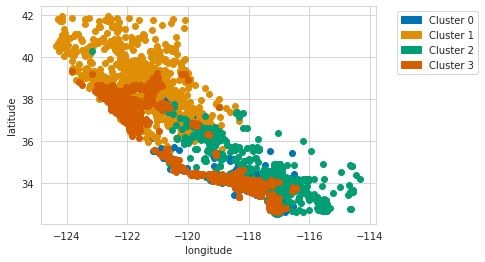

Treino


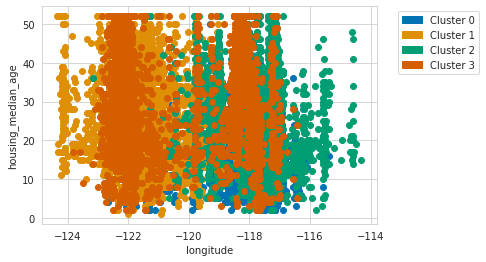

Treino


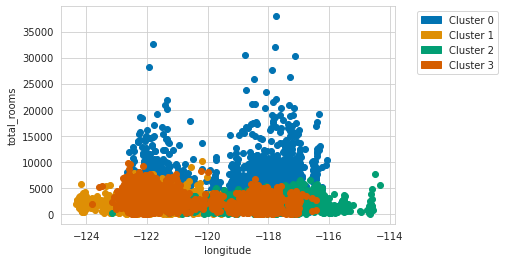

Treino


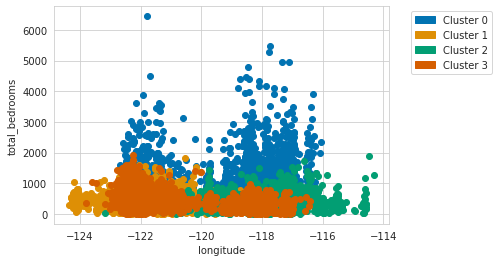

Treino


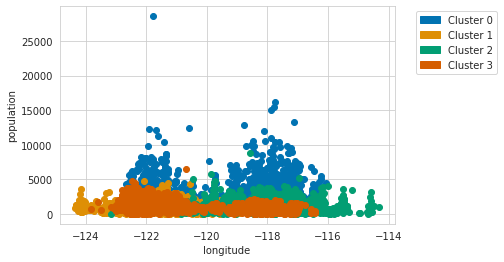

Treino


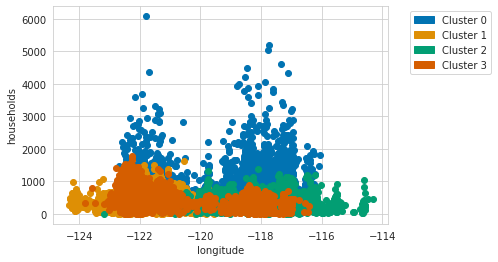

Treino


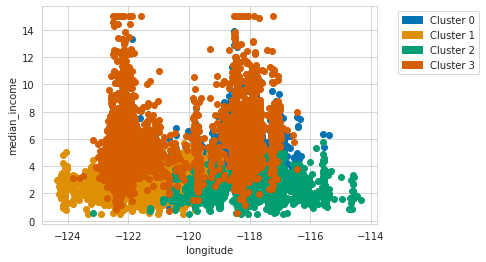

Treino


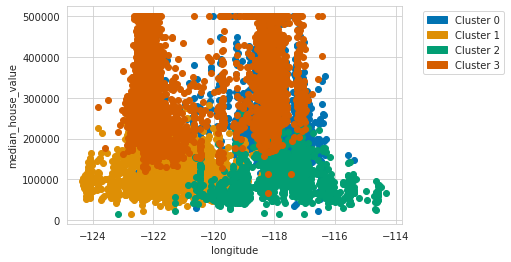

Treino


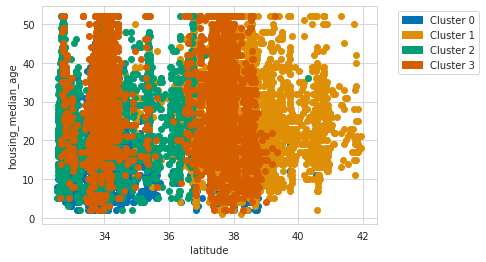

Treino


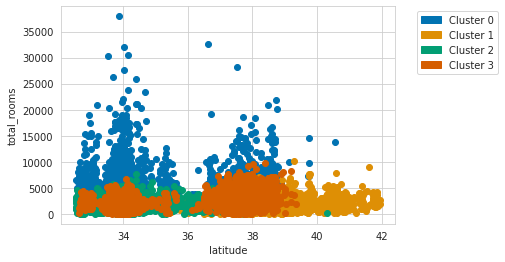

Treino


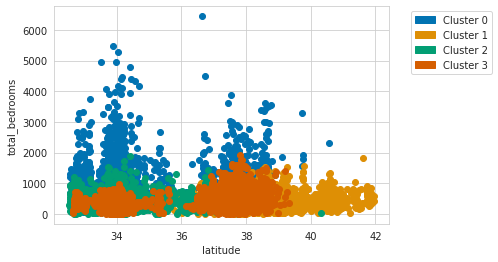

Treino


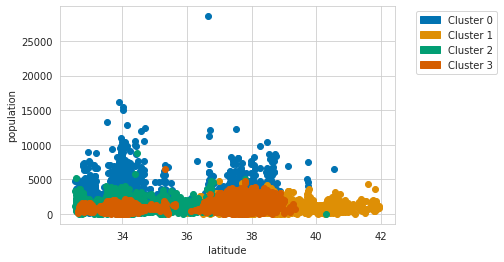

Treino


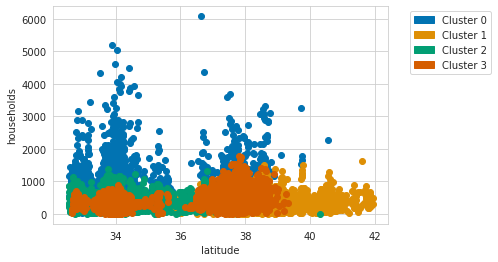

Treino


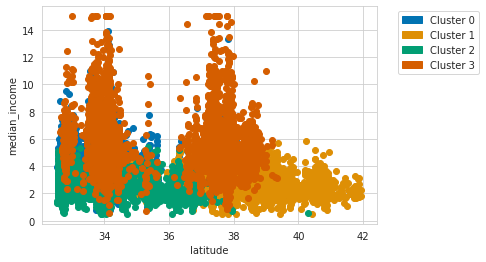

Treino


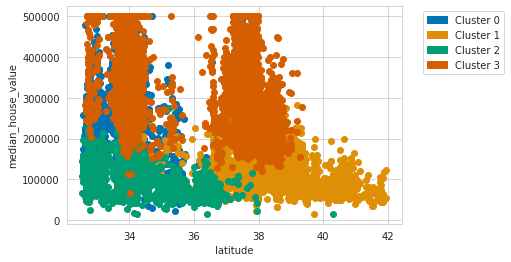

Treino


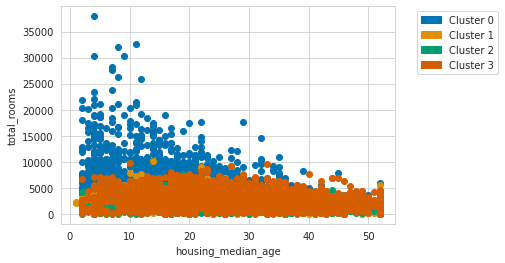

Treino


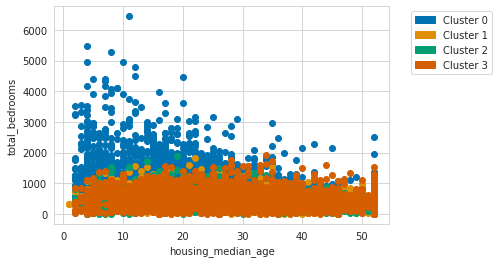

Treino


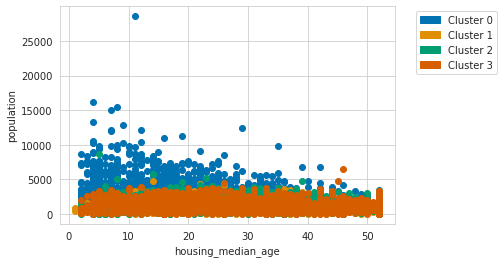

Treino


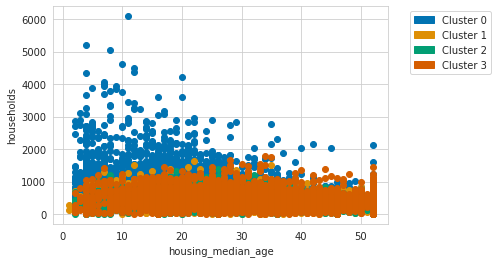

Treino


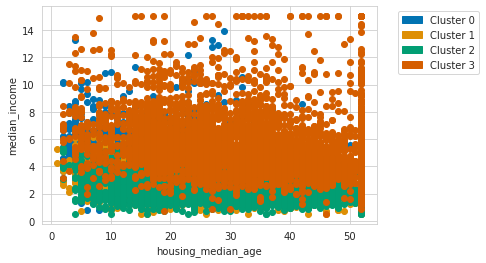

Treino


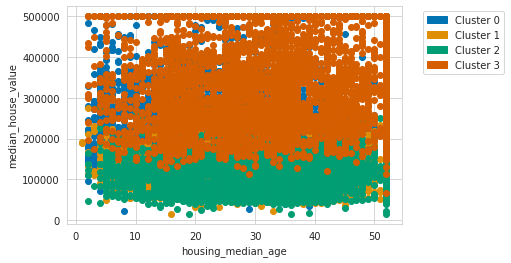

Treino


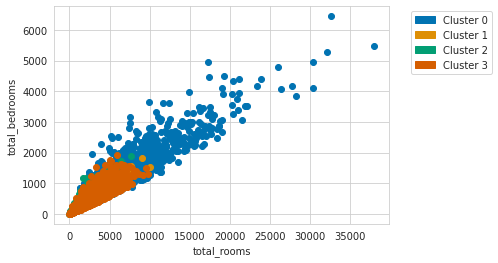

Treino


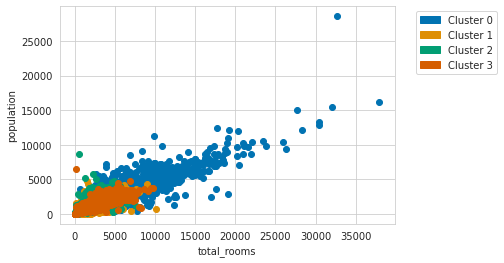

Treino


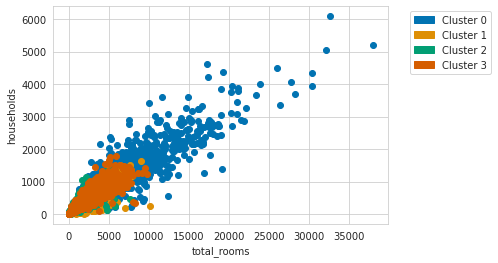

Treino


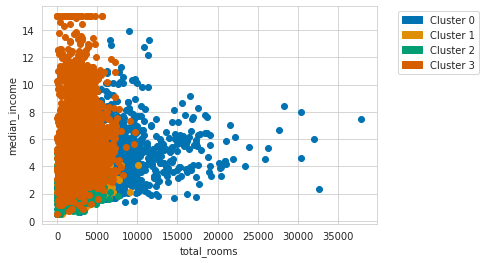

Treino


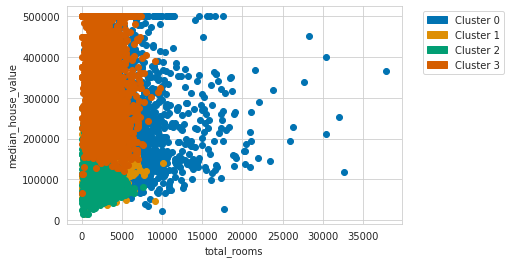

Treino


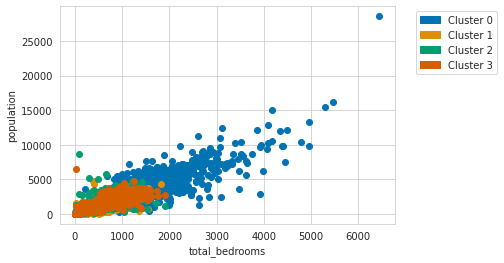

Treino


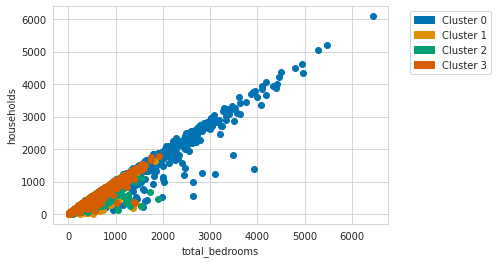

Treino


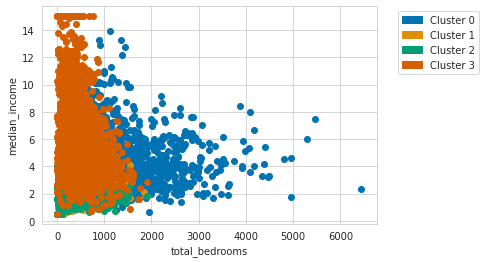

Treino


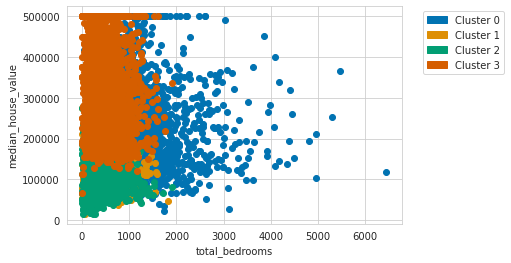

Treino


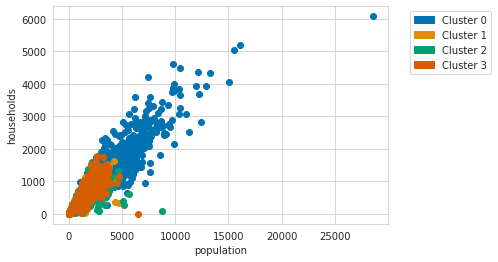

Treino


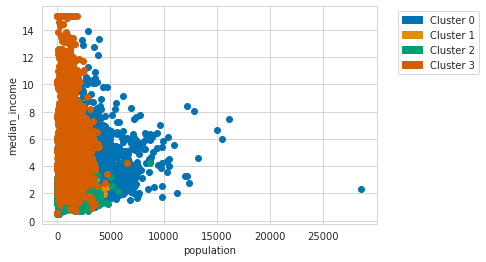

Treino


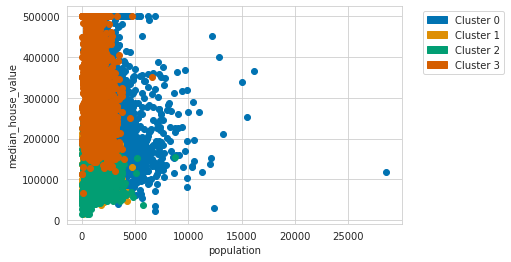

Treino


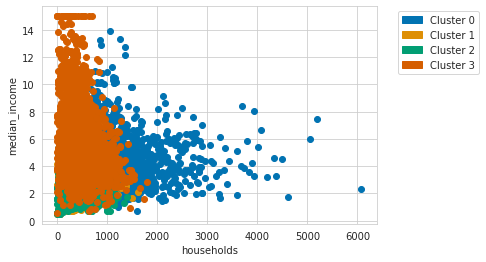

Treino


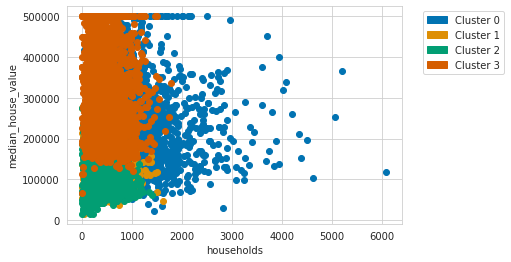

Treino


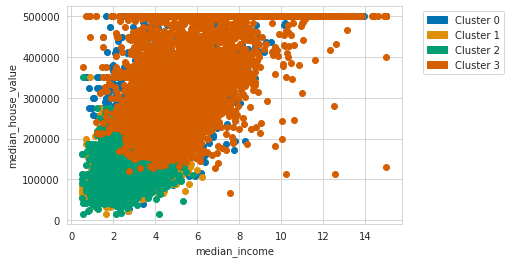

In [520]:
df_aux = df.loc[mask_treino, features].copy()
df_aux['Cluster'] = clusters_treino

comb_columns = list(itertools.combinations(features, 2))

def f(x, comb):
  d = {}
  for c in comb:
    d[c] = np.hstack(x[c].values)
  return pd.Series(d)

for comb in comb_columns:
  df_temp = df_aux.groupby('Cluster').apply(lambda x: f(x, comb))
  print('Treino')
  plot_bivariadas_clusters(df_temp, frac = 1, alpha = 1, seed = 42, figsize = [6, 4])

Teste


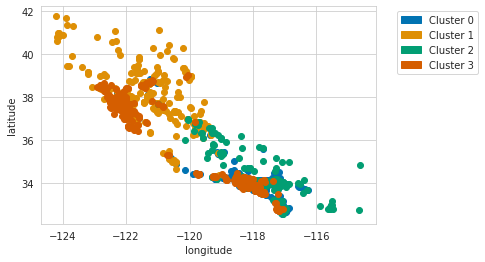

Teste


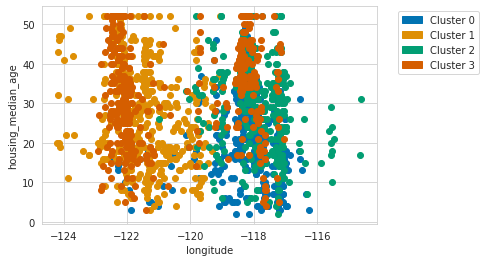

Teste


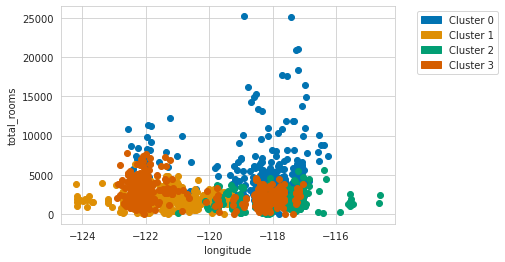

Teste


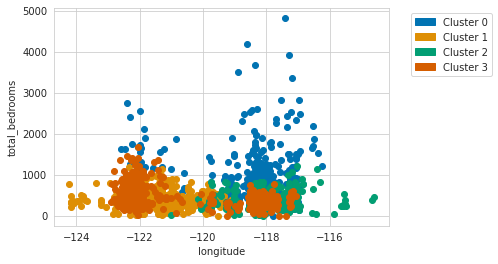

Teste


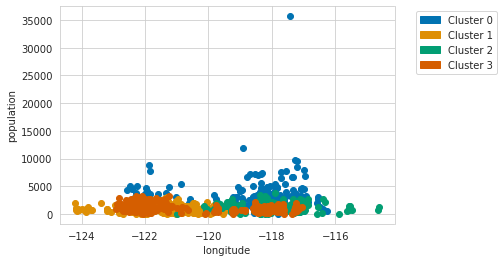

Teste


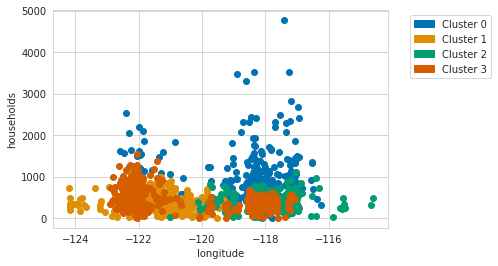

Teste


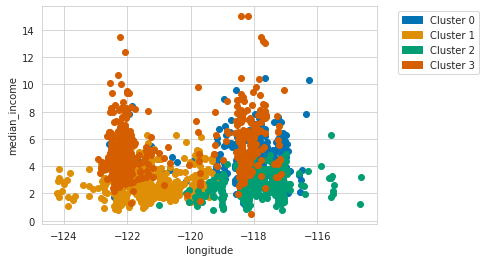

Teste


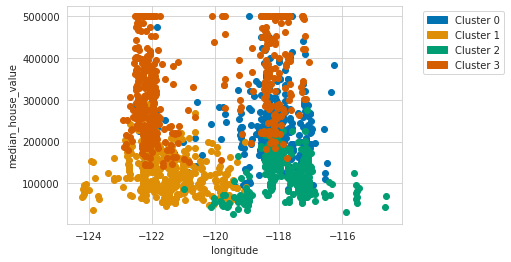

Teste


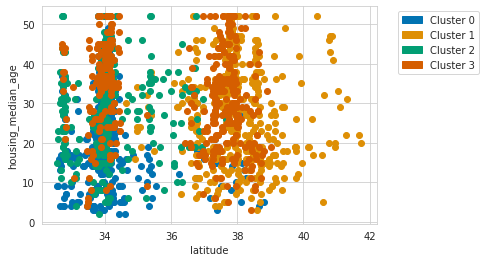

Teste


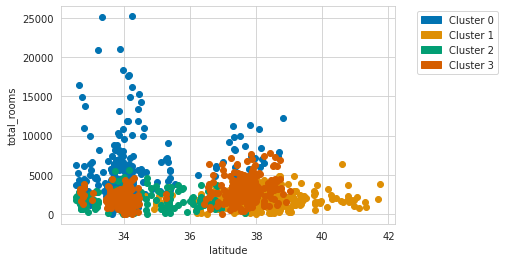

Teste


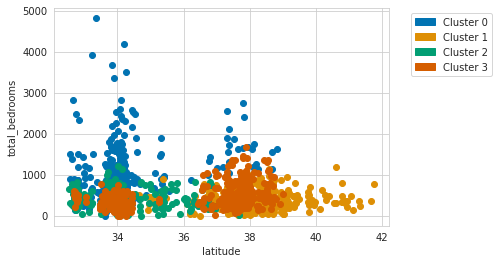

Teste


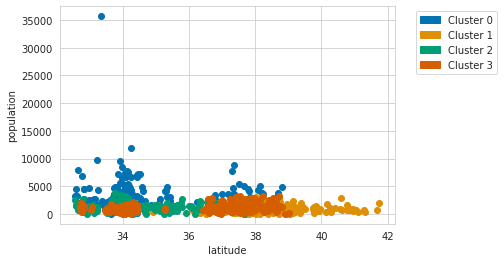

Teste


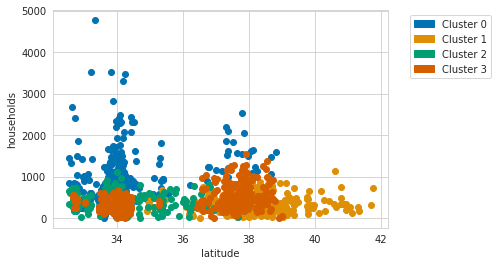

Teste


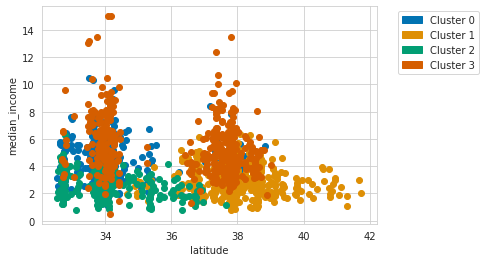

Teste


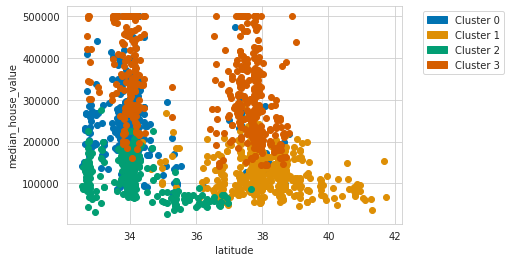

Teste


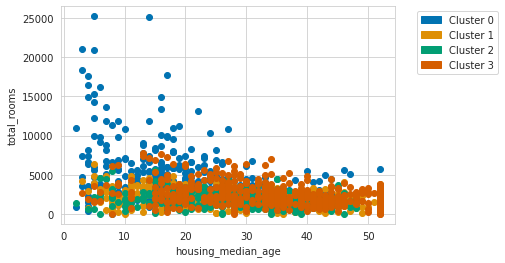

Teste


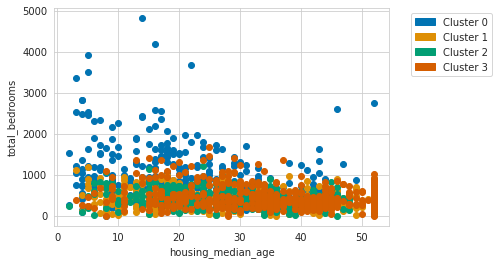

Teste


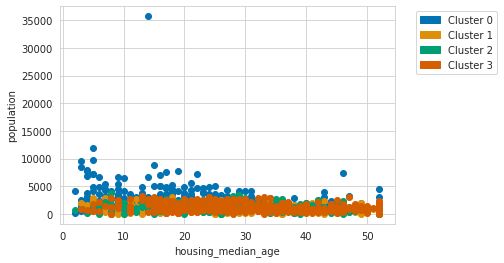

Teste


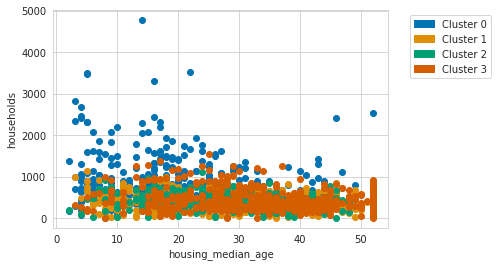

Teste


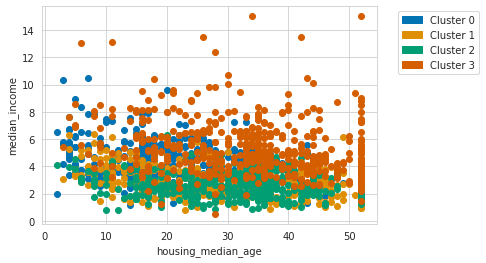

Teste


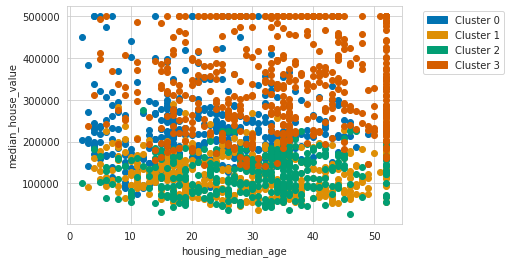

Teste


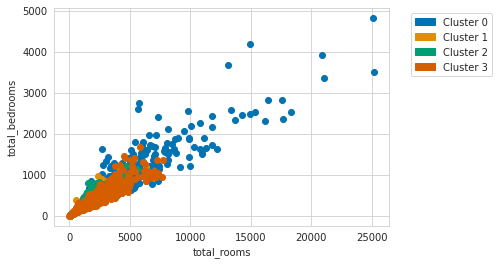

Teste


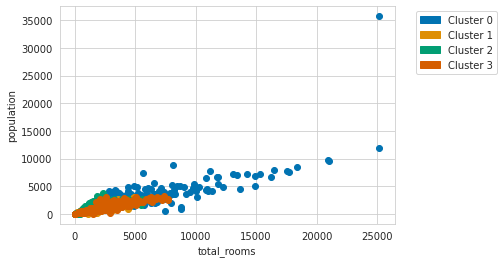

Teste


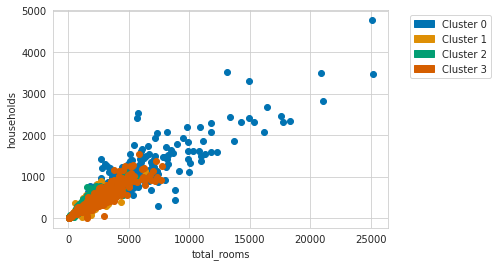

Teste


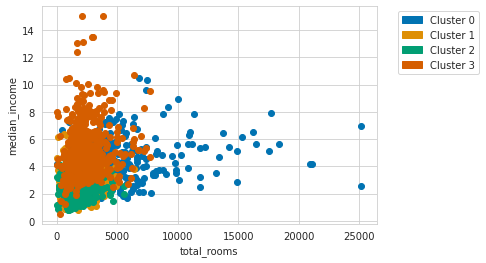

Teste


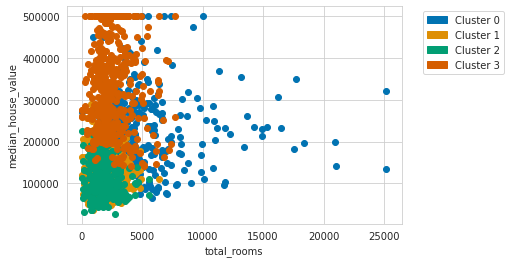

Teste


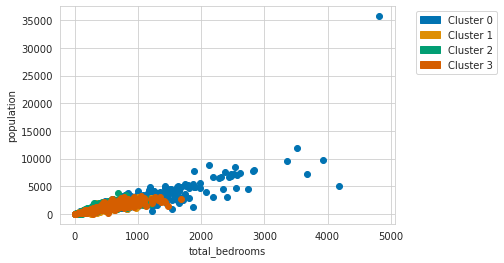

Teste


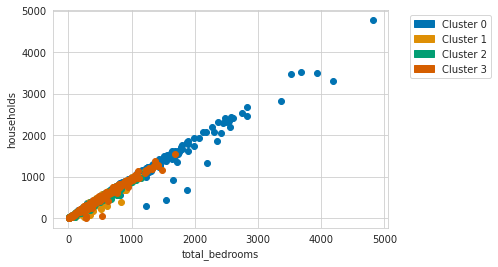

Teste


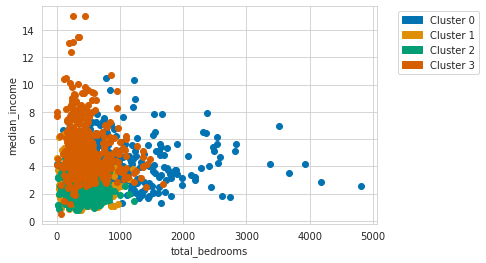

Teste


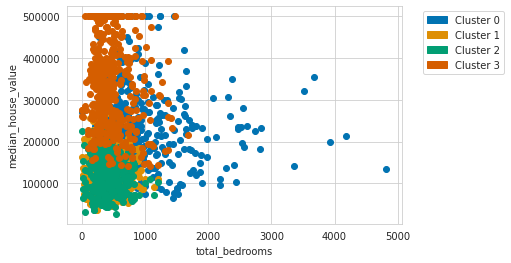

Teste


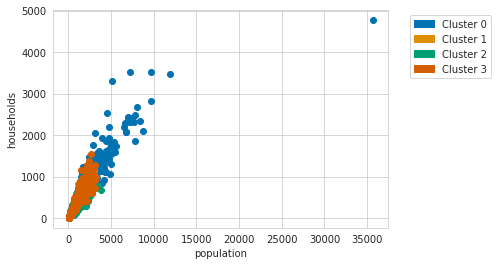

Teste


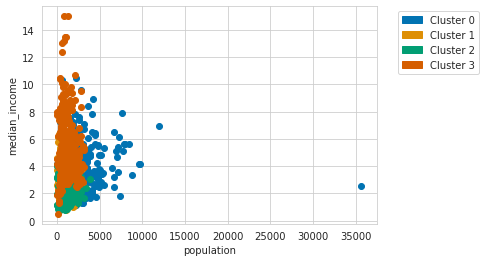

Teste


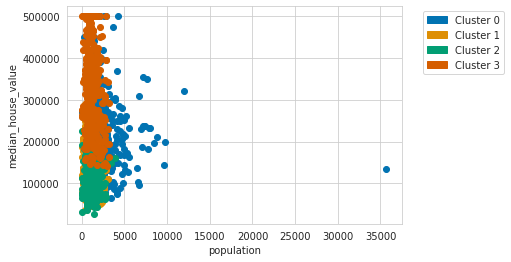

Teste


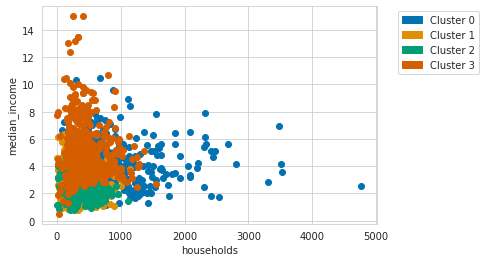

Teste


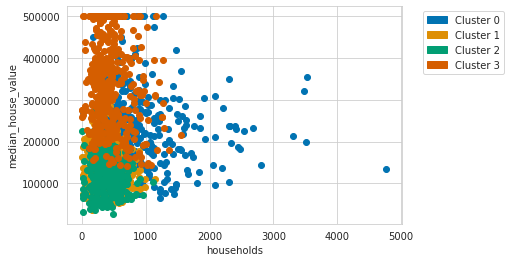

Teste


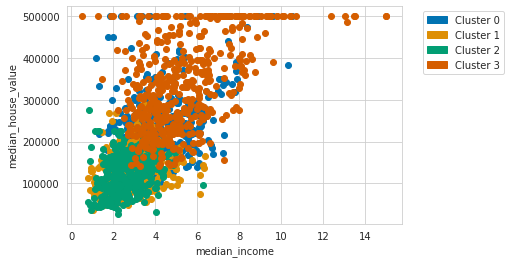

In [521]:
df_aux = df.loc[mask_teste, features].copy()
df_aux['Cluster'] = clusters_teste

comb_columns = list(itertools.combinations(features, 2))

def f(x, comb):
  d = {}
  for c in comb:
    d[c] = np.hstack(x[c].values)
  return pd.Series(d)

for comb in comb_columns:
  df_temp = df_aux.groupby('Cluster').apply(lambda x: f(x, comb))
  print('Teste')
  plot_bivariadas_clusters(df_temp, frac = 1, alpha = 1, seed = 42, figsize = [6, 4])

# Análises Anomalias

In [65]:
def plot_bivariadas_anomalias(df, frac = 1, alpha = 0.1, seed = 42, figsize = [6, 4]):
  paleta_cores = sns.color_palette("colorblind")
  with sns.axes_style("whitegrid"):
      fig, ax = plt.subplots(1, 1, figsize = figsize)
      hlds = []
      for cluster in df.index:
        if(cluster == -1):
          x = df.loc[cluster, df.columns[0]]
          y = df.loc[cluster, df.columns[1]]
          random.seed(seed)
          indices = random.sample(list(range(0, x.size)), int(frac*x.size))
          ax.scatter(x[indices], y[indices], alpha = alpha, color = 'black')
          hlds.append(mpl.patches.Patch(color = 'black', label = f'Anomalia {str(cluster)}'))
        else:
          x = df.loc[cluster, df.columns[0]]
          y = df.loc[cluster, df.columns[1]]
          random.seed(seed)
          indices = random.sample(list(range(0, x.size)), int(frac*x.size))
          ax.scatter(x[indices], y[indices], alpha = alpha, color = paleta_cores[cluster])
          hlds.append(mpl.patches.Patch(color = paleta_cores[cluster], label = f'Anomalia {str(cluster)}'))
      ax.set_xlabel(df.columns[0])
      ax.set_ylabel(df.columns[1])
      ax.legend(handles = hlds, bbox_to_anchor = (1.05, 1), loc = 'upper left')
      plt.show()

In [66]:
print('Treino')
df_aux = df.loc[mask_treino, features].copy()
df_aux['Anomalia'] = grau_an_treino > corte_anomalia
display(df_aux.groupby('Anomalia').mean())

print('Teste')
df_aux = df.loc[mask_teste, features].copy()
df_aux['Anomalia'] = grau_an_teste > corte_anomalia
display(df_aux.groupby('Anomalia').mean())

Treino


V1        V2        V3  ...       V27       V28      Amount
Anomalia                                ...                                
False     0.052014  0.008077  0.111152  ...  0.001919  0.002305   85.586697
True     -7.964051 -2.605562 -2.955148  ... -0.249902 -0.156653  568.737373

[2 rows x 29 columns]

Teste


V1        V2        V3  ...       V27       V28      Amount
Anomalia                                ...                                
False     0.300768  0.172646 -0.710659  ...  0.008260 -0.004995   66.643930
True     -5.973761 -1.170515 -2.531195  ... -0.369658 -0.195696  474.830599

[2 rows x 29 columns]

Treino


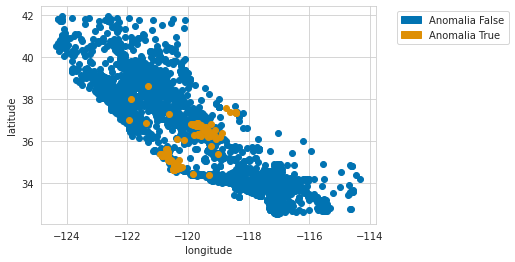

Treino


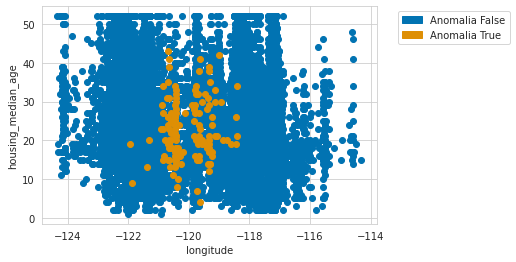

Treino


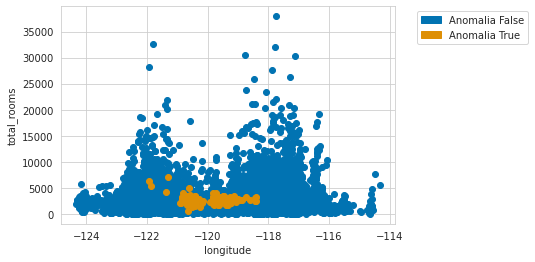

Treino


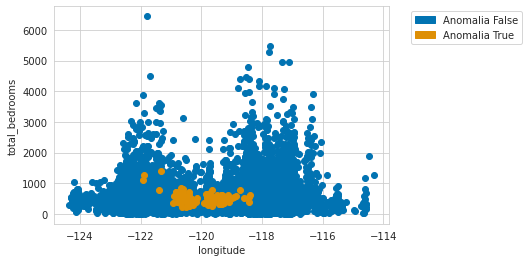

Treino


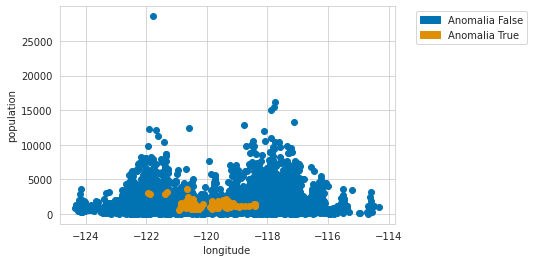

Treino


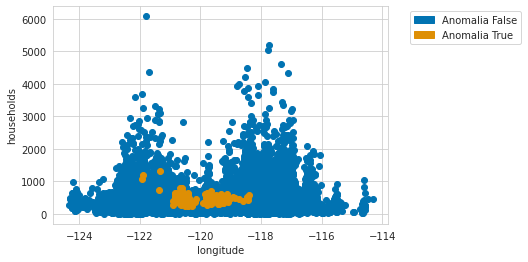

Treino


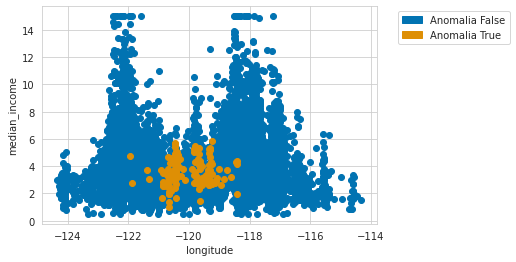

Treino


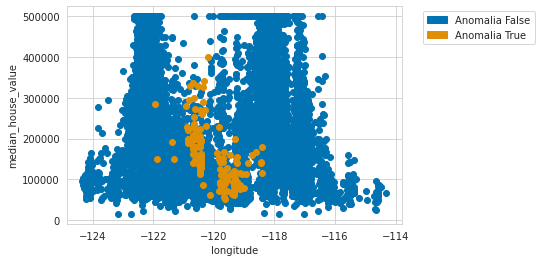

Treino


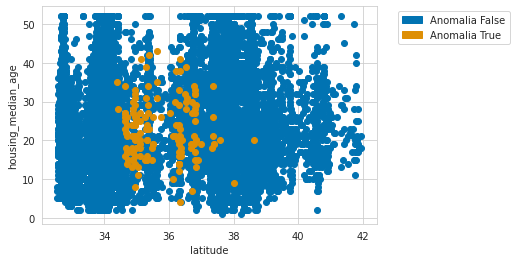

Treino


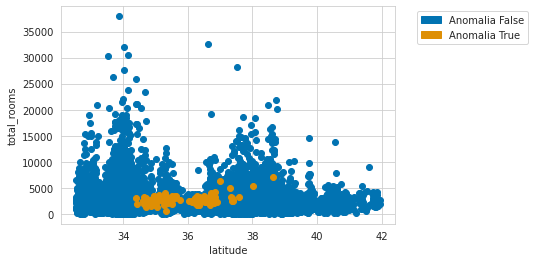

Treino


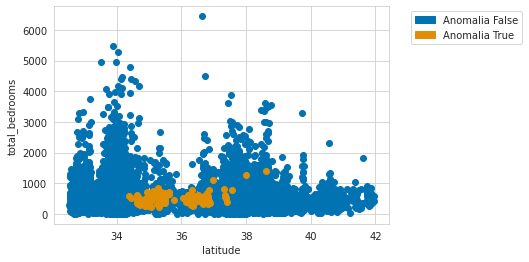

Treino


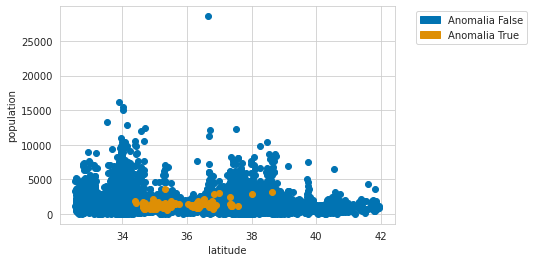

Treino


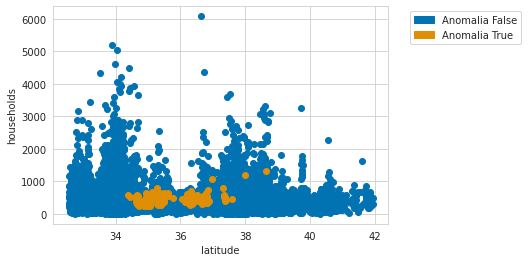

Treino


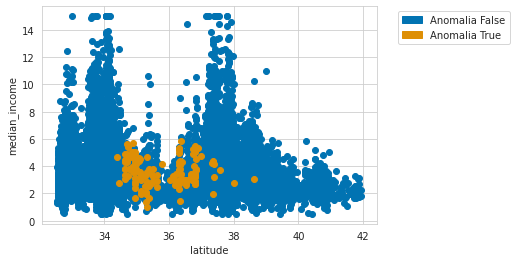

Treino


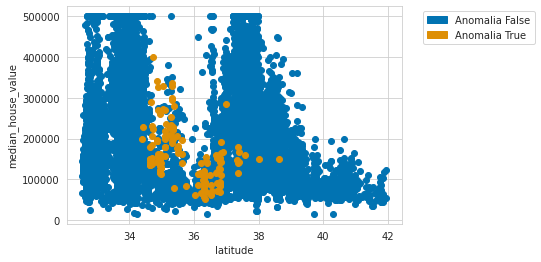

Treino


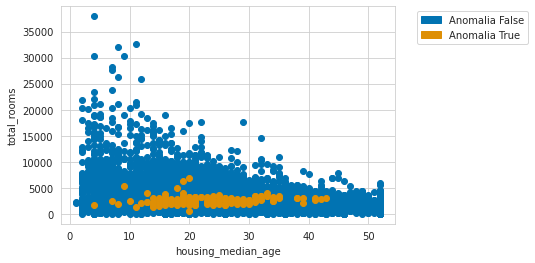

Treino


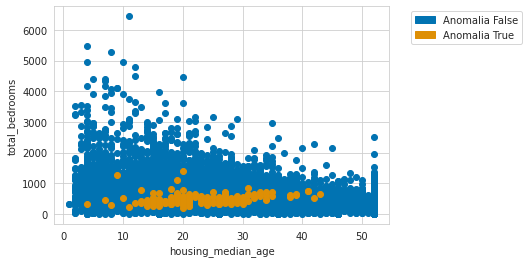

Treino


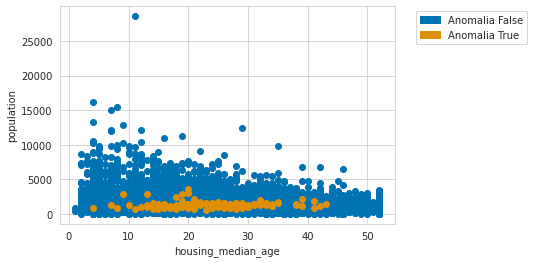

Treino


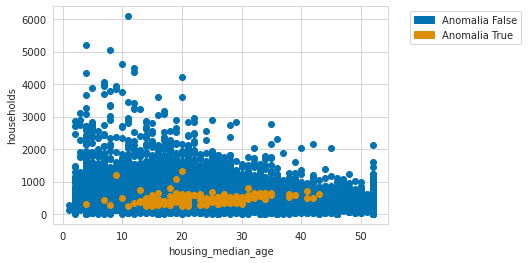

Treino


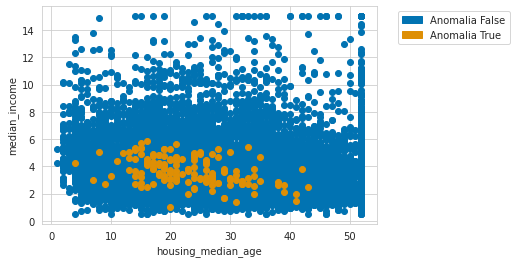

Treino


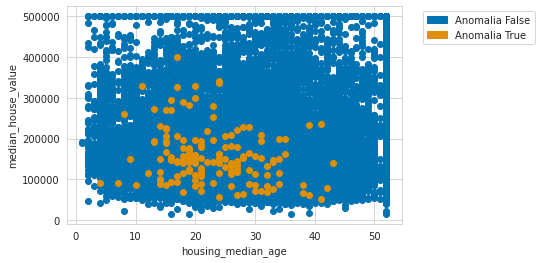

Treino


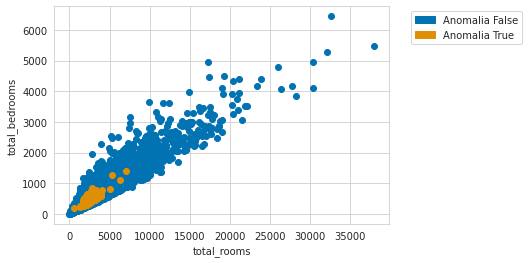

Treino


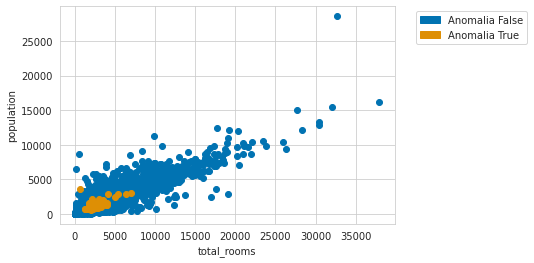

Treino


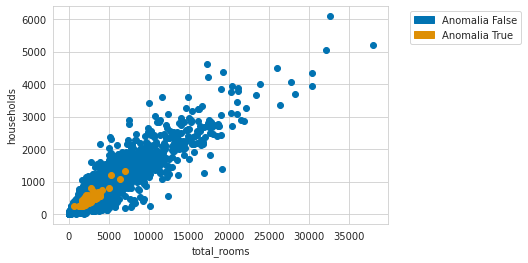

Treino


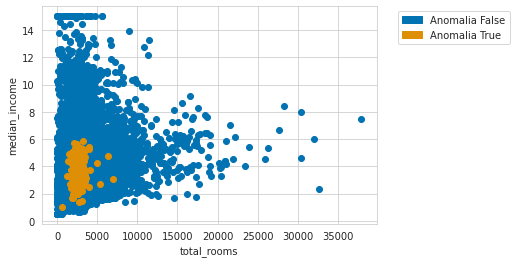

Treino


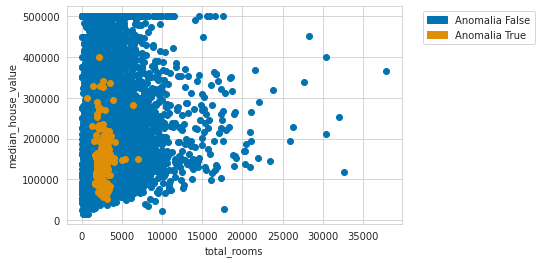

Treino


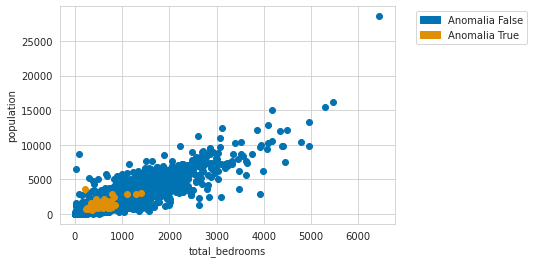

Treino


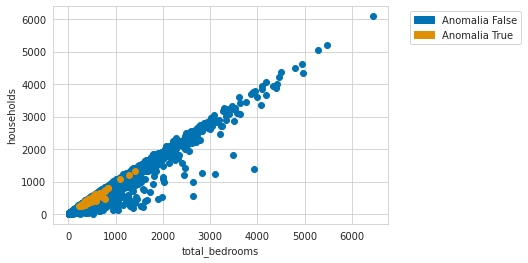

Treino


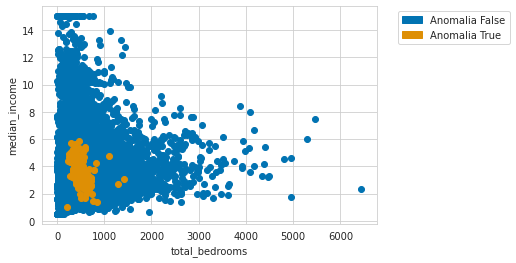

Treino


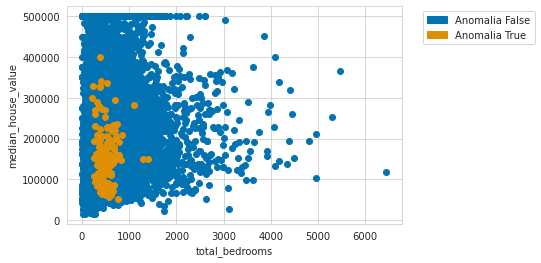

Treino


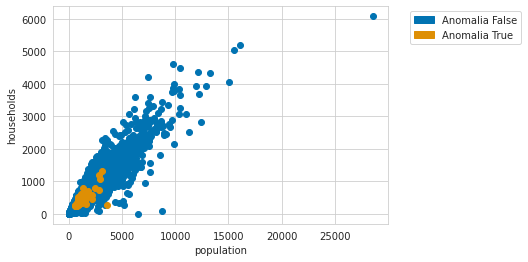

Treino


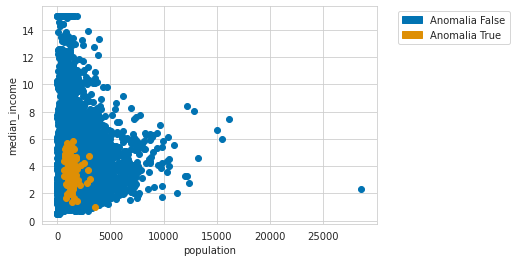

Treino


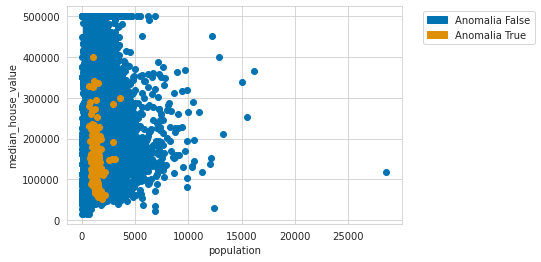

Treino


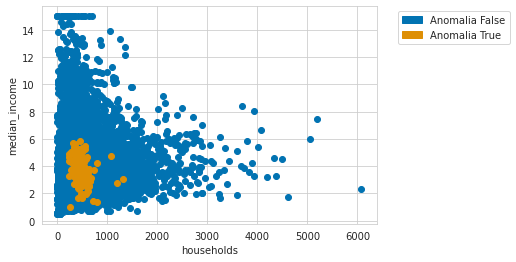

Treino


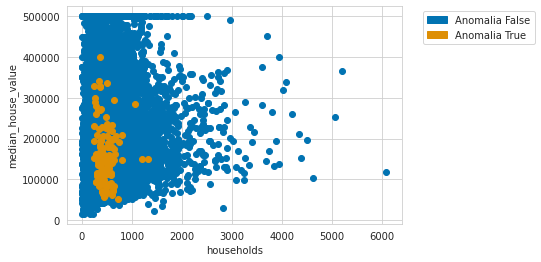

Treino


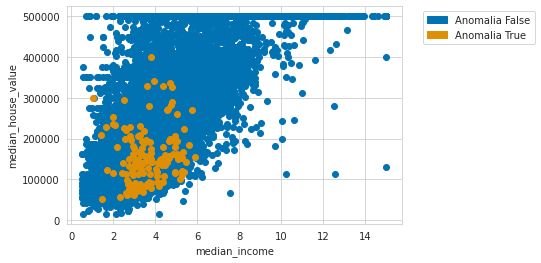

In [524]:
df_aux = df.loc[mask_treino, features].copy()
df_aux['Anomalia'] = grau_an_treino > corte_anomalia

comb_columns = list(itertools.combinations(features, 2))

def f(x, comb):
  d = {}
  for c in comb:
    d[c] = np.hstack(x[c].values)
  return pd.Series(d)

for comb in comb_columns:
  df_temp = df_aux.groupby('Anomalia').apply(lambda x: f(x, comb))
  print('Treino')
  plot_bivariadas_anomalias(df_temp, frac = 1, alpha = 1, seed = 42, figsize = [6, 4])

Teste


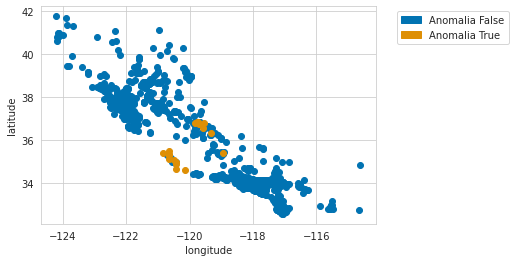

Teste


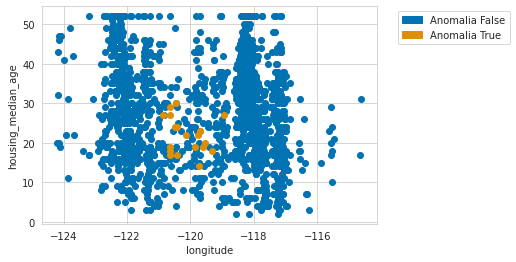

Teste


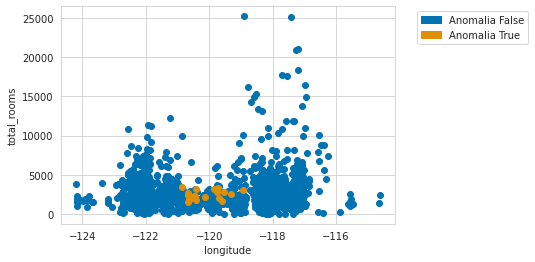

Teste


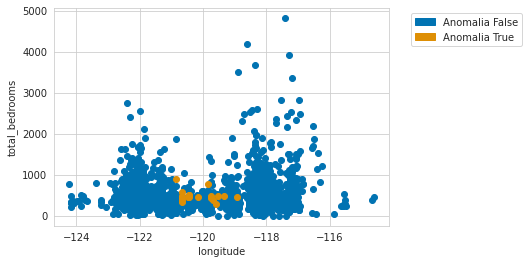

Teste


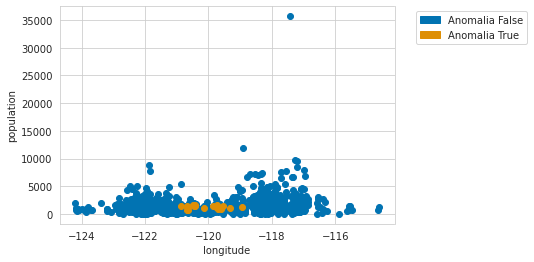

Teste


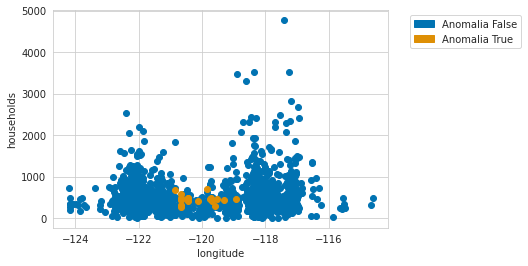

Teste


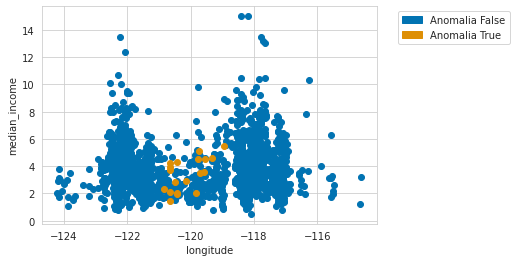

Teste


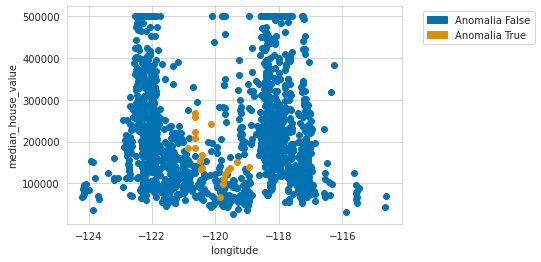

Teste


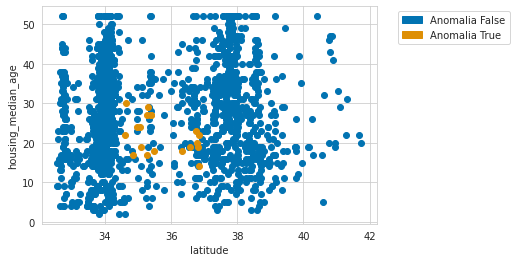

Teste


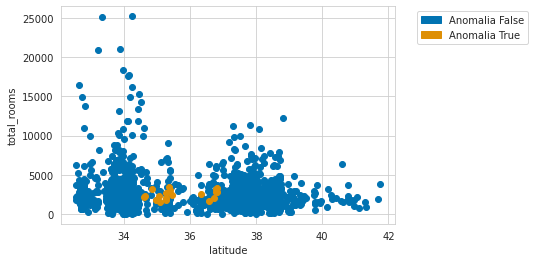

Teste


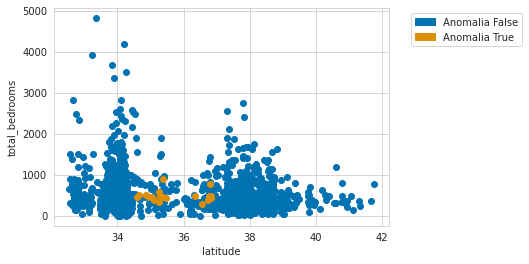

Teste


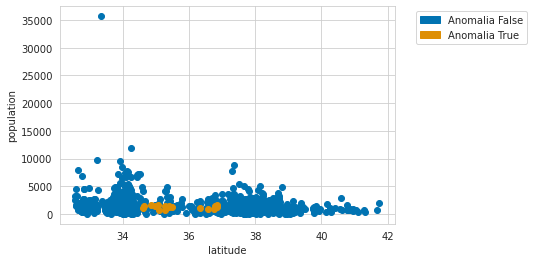

Teste


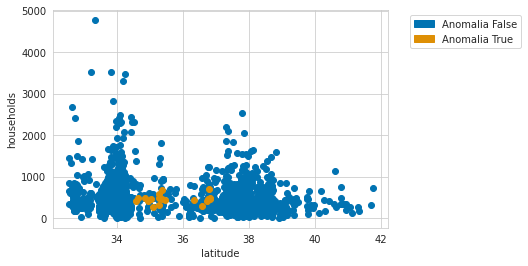

Teste


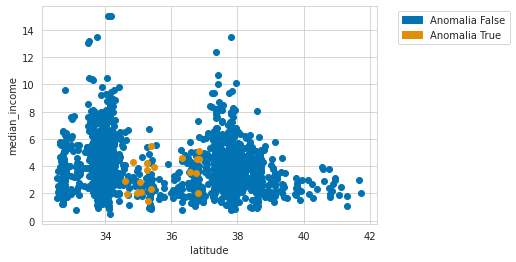

Teste


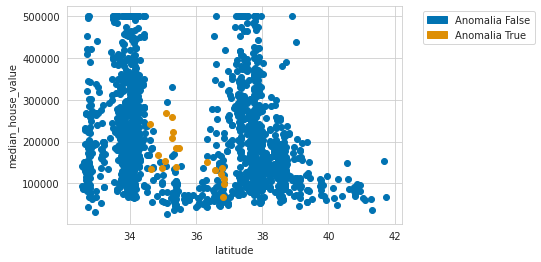

Teste


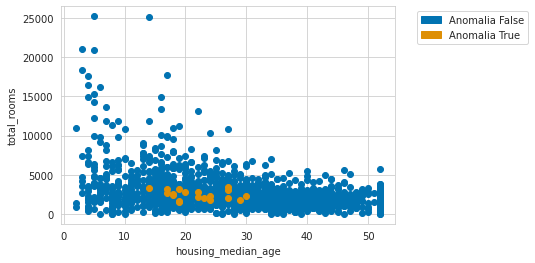

Teste


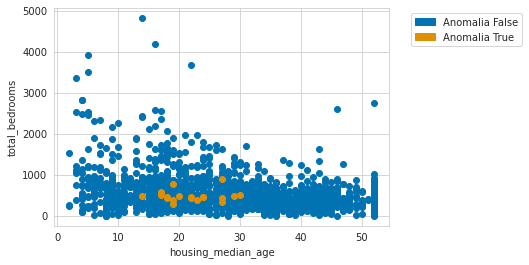

Teste


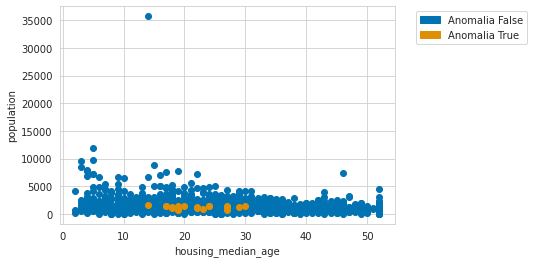

Teste


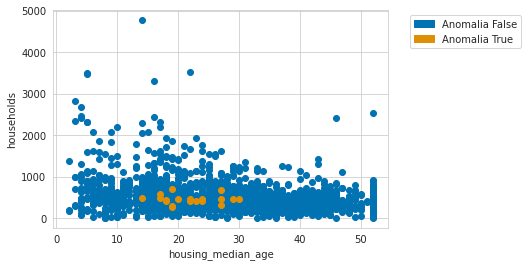

Teste


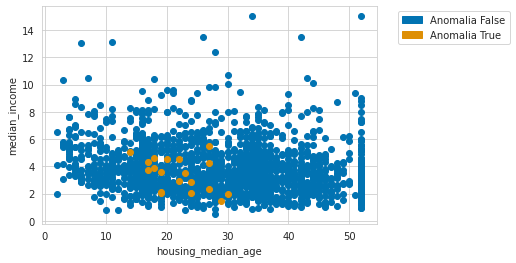

Teste


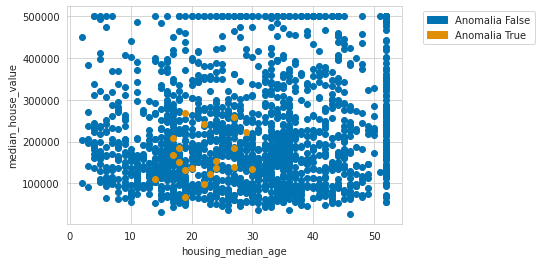

Teste


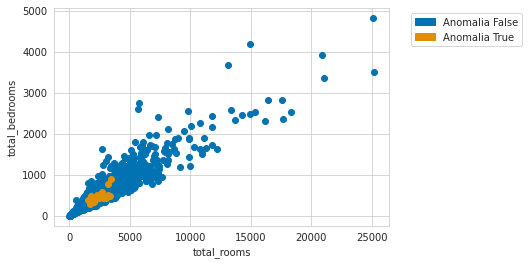

Teste


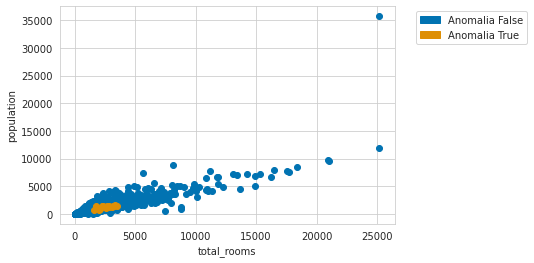

Teste


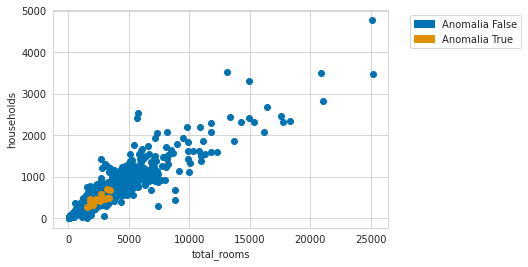

Teste


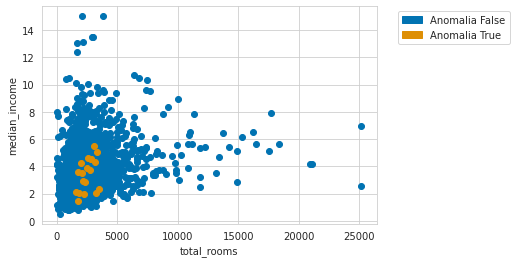

Teste


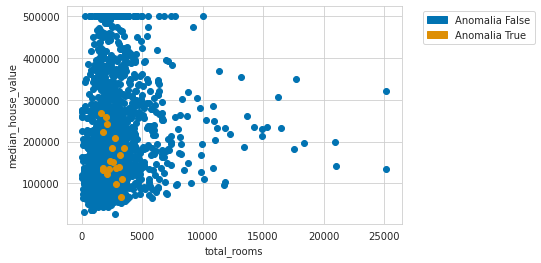

Teste


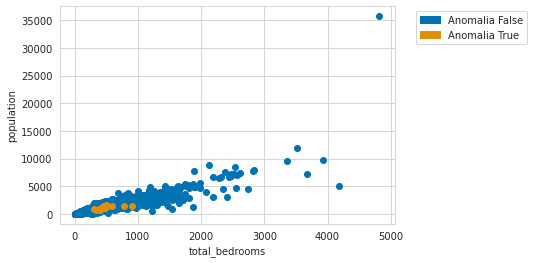

Teste


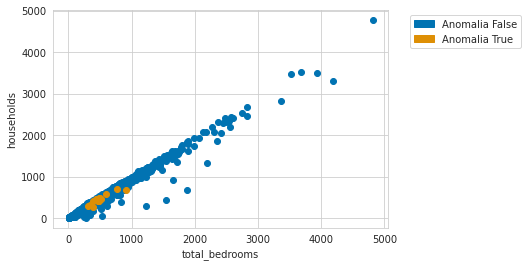

Teste


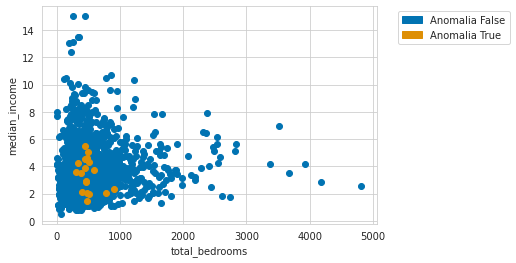

Teste


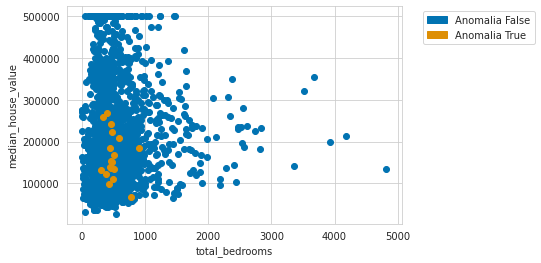

Teste


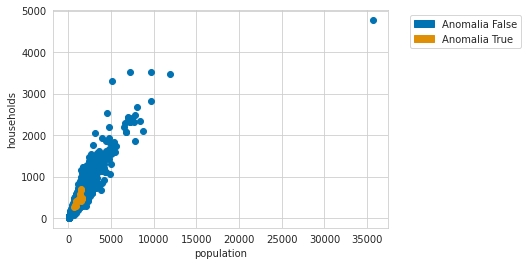

Teste


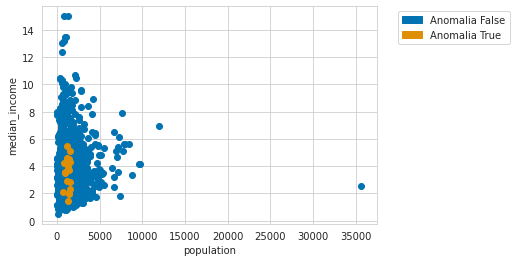

Teste


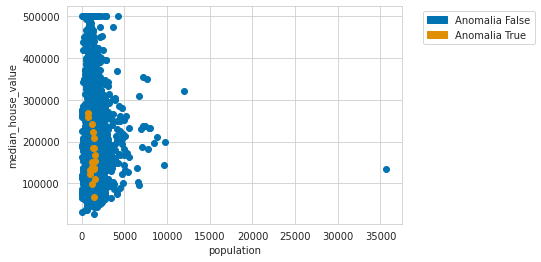

Teste


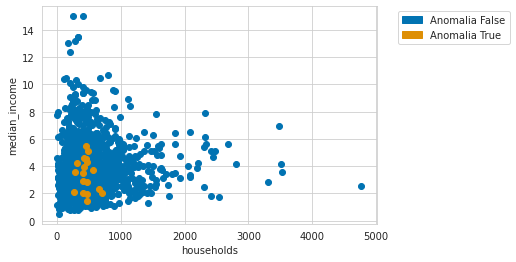

Teste


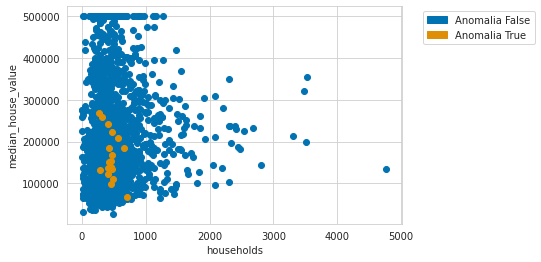

Teste


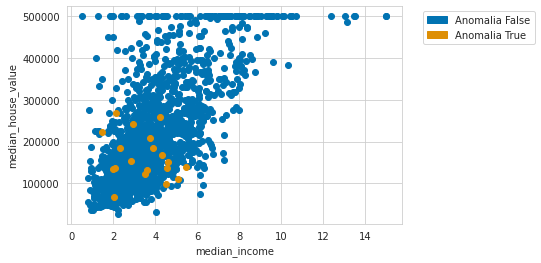

In [525]:
df_aux = df.loc[mask_teste, features].copy()
df_aux['Anomalia'] = grau_an_teste > corte_anomalia

comb_columns = list(itertools.combinations(features, 2))

def f(x, comb):
  d = {}
  for c in comb:
    d[c] = np.hstack(x[c].values)
  return pd.Series(d)

for comb in comb_columns:
  df_temp = df_aux.groupby('Anomalia').apply(lambda x: f(x, comb))
  print('Teste')
  plot_bivariadas_anomalias(df_temp, frac = 1, alpha = 1, seed = 42, figsize = [6, 4])

### Análise Clusters - Alvo Oculto

In [67]:
def g(x):
  y = (x[alvo].value_counts()/x.shape[0])
  d = {}
  for ind in y.index:
    d[ind] = y[ind]
  return pd.DataFrame(pd.Series(d, name = '')).transpose()

In [68]:
print('Treino')
df_aux = df.loc[mask_treino, [alvo]].copy()
df_aux['Cluster'] = clusters_treino
df_res = pd.DataFrame(df_aux.groupby('Cluster').apply(lambda x: g(x)))
display(df_res)

print('Teste')
df_aux = df.loc[mask_teste, [alvo]].copy()
df_aux['Cluster'] = clusters_teste
df_res = pd.DataFrame(df_aux.groupby('Cluster').apply(lambda x: g(x)))
display(df_res)

Treino


'0'       '1'
Cluster                     
0         0.999277  0.000723
1         0.993891  0.006109
2         0.998926  0.001074
3         0.999863  0.000137

Teste


'0'       '1'
Cluster                     
0         1.000000       NaN
1         0.998257  0.001743
2         0.999794  0.000206
3         0.999592  0.000408

### Análise Anomalias - Alvo Oculto

In [69]:
print('Treino')
df_aux = df.loc[mask_treino, [alvo]].copy()
df_aux['Anomalia'] = grau_an_treino > corte_anomalia
df_res = pd.DataFrame(df_aux.groupby('Anomalia').apply(lambda x: g(x)))
display(df_res)

print('Teste')
df_aux = df.loc[mask_teste, [alvo]].copy()
df_aux['Anomalia'] = grau_an_teste > corte_anomalia
df_res = pd.DataFrame(df_aux.groupby('Anomalia').apply(lambda x: g(x)))
display(df_res)

Treino


'0'       '1'
Anomalia                     
False      0.998644  0.001356
True       0.950820  0.049180

Teste


'0'       '1'
Anomalia                     
False      0.999328  0.000672
True       0.986175  0.013825

In [70]:
print('Treino')
df_aux = df.loc[mask_treino, [alvo]].copy()
df_aux['Grau_Anomalia'] = grau_an_treino
df_res = pd.DataFrame(df_aux.groupby(alvo).agg(['mean', 'std', 'max', 'min']))
display(df_res)

print('Teste')
df_aux = df.loc[mask_teste, [alvo]].copy()
df_aux['Grau_Anomalia'] = grau_an_teste
df_res = pd.DataFrame(df_aux.groupby(alvo).agg(['mean', 'std', 'max', 'min']))
display(df_res)

Treino


Grau_Anomalia                                 
               mean        std         max       min
Class                                               
'0'        0.519009   1.657945  284.772719  0.045782
'1'        4.262737  10.277383  111.769182  0.151193

Teste


Grau_Anomalia                                 
               mean       std          max       min
Class                                               
'0'        0.505657  6.738034  1117.238602  0.046132
'1'        1.968884  2.548997    11.740446  0.178106

In [75]:
df_treino = df.loc[mask_treino, [alvo]].copy()
df_treino['Grau_Anomalia'] = grau_an_treino
df_treino[alvo] = df_treino[alvo].str.replace("'", '').astype(int)

df_teste = df.loc[mask_teste, [alvo]].copy()
df_teste['Grau_Anomalia'] = grau_an_teste
df_teste[alvo] = df_teste[alvo].str.replace("'", '').astype(int)

dict_dfs_clf = {'Treino': df_treino, 'Teste': df_teste}

avalia = aml.AvaliaDatasetsClassificacao(dict_dfs_clf, alvo, 'Grau_Anomalia', num_div_prob = 100)
display(avalia.valor_metricas().loc[['AUC', 'KS', 
                                    'LiftV_10', 'LiftV_20', 
                                    'IG', 'Prob_Corte', 
                                    'Acurácia', 'Acurácia_Balanceada']])

Treino     Teste
AUC                  0.913175  0.877666
KS                   0.697144  0.698431
LiftV_10             0.775532  0.750000
LiftV_20             0.886170  0.840909
IG                   0.188999  0.157212
Prob_Corte           1.055604  0.728839
Acurácia             0.936514  0.941996
Acurácia_Balanceada  0.824846  0.743879